## Comparing the KC and STL metro areas
### Part 1: gathering the data
#### Part 1.1: getting the cities in each metro area



In [1]:
#import packages needed for project
import geocoder as geo
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np

In [7]:
#function to get longitude and latitude of locations from given table
def getlatlong(states,cities=[],counties=[]):
    
    url='http://www.mapquestapi.com/geocoding/v1/address'
    #checking for if cities or counties was entered.
    if (len(cities)==0):
        location=pd.DataFrame(columns=['lat','lng']) 
        #for loop to retrieve latitutde and longitude for each county (or state later in code)
        #from mapquest
        for county,state in zip(counties,states):
            params=dict(
            key='nbkIDYmvGyIvaWrFKBqwo8ZG7FqBUklA',
            location='{} County, {}'.format(county,state))
            latlng=requests.get(url=url,params=params).json()['results'][0]['locations'][0]['latLng']
            latlng=np.array([latlng['lat'],latlng['lng']])
            latlng2=pd.DataFrame(latlng).T
            latlng2.columns=['lat','lng']           
            location=location.append(latlng2)
    else:
        location=pd.DataFrame(columns=['lat','lng']) 
        for city,state in zip(cities,states):
            params=dict(
            key='nbkIDYmvGyIvaWrFKBqwo8ZG7FqBUklA',
            location='{}, {}'.format(city,state))
            latlng=requests.get(url=url,params=params).json()['results'][0]['locations'][0]['latLng']
            latlng=np.array([latlng['lat'],latlng['lng']])
            latlng2=pd.DataFrame(latlng).T
            latlng2.columns=['lat','lng']           
            location=location.append(latlng2)
    return(location)

In [9]:
#using KC metro page on wikipedia to get list of cities in it
url='https://en.wikipedia.org/wiki/Kansas_City_metropolitan_area#Counties'
htmlscript=requests.get(url).content
soup=BeautifulSoup(htmlscript,'html.parser')

In [10]:
#help see how the document is structured
print(soup.prettify())


<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Kansas City metropolitan area - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"Xkip0QpAAEUAADBZMOcAAABM","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Kansas_City_metropolitan_area","wgTitle":"Kansas City metropolitan area","wgCurRevisionId":940736314,"wgRevisionId":940736314,"wgArticleId":572408,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Webarchive template

In [11]:
# pulling the cities from the unstructured list on the wiki page. Individually add kansas city, missouri to save some space
firstsection=soup.find_all(attrs={'class':'multicol-float'})[0].find_all('a')
secondsection=soup.find_all(attrs={'class':'multicol-float'})[1].find_all('a')
KCcitieslist=firstsection+secondsection
KC={'City':['Kansas City'],'State':['Missouri']}
KCcitiesdf=pd.DataFrame(KC)
# for loop splits cities and states
for i in range(0,len(KCcitieslist)):
    temp=KCcitieslist[i].string.split(',')
    tempdic={'City':[temp[0]],'State':[temp[1]]}
    tempdf=pd.DataFrame(tempdic)
    KCcitiesdf=KCcitiesdf.append(tempdf)
KCcitiesdf

,City,State
0,Kansas City,Missouri
0,Overland Park,Kansas
0,Kansas City,Kansas
0,Olathe,Kansas
0,Independence,Missouri
...,...,...
0,Oaks,Missouri
0,Unity Village,Missouri
0,Levasy,Missouri
0,Randolph,Missouri


In [12]:
KCcitiesdf2=KCcitiesdf
KCcitiesdf2.head(10)

,City,State
0,Kansas City,Missouri
0,Overland Park,Kansas
0,Kansas City,Kansas
0,Olathe,Kansas
0,Independence,Missouri
0,Lee's Summit,Missouri
0,Shawnee,Kansas
0,Lenexa,Kansas
0,Blue Springs,Missouri
0,Leavenworth,Kansas


In [13]:
#getting coordinates for the city.
cityCoordinates=getlatlong(states=KCcitiesdf2['State'],cities=KCcitiesdf2['City'])
cityCoordinates

,lat,lng
0,39.099792,-94.578559
0,38.974799,-94.683622
0,39.112700,-94.626804
0,38.883525,-94.818236
0,39.093659,-94.412017
...,...,...
0,39.196532,-94.571219
0,38.951250,-94.394921
0,39.133546,-94.131669
0,39.158831,-94.495323


In [14]:
#fixing up the index on the dataframes and combining city,state dataframe with the coordinates
KCcitdf3=KCcitiesdf2.reset_index().drop('index',1)
citycoord2=cityCoordinates.reset_index().drop('index',1)
KCcitdf3=KCcitdf3.join(citycoord2)

In [15]:
KCcitdf3.shape

(79, 4)

Time to extract data for greater St. Louis Area


In [16]:
url='https://en.wikipedia.org/wiki/Greater_St._Louis'
htmlscript=requests.get(url).content
soup=BeautifulSoup(htmlscript,'html.parser')

Now for the cities of St. Louis

In [22]:
#cities in st. louis wiki were nicer but the for lop goes through each heading for each county
countylist=soup.find_all('b')[25:40]
citiesdf=pd.DataFrame(columns=['City','State'])
for i in range(0,len(countylist)):
    tempcitylst=countylist[i].find_next_siblings('a')
    for k in range(0,len(tempcitylst)):
        tempcity=tempcitylst[k].get('title').split(',')
        if(len(tempcity)==1):
            tempcity.append('NA')
        tempdf=pd.DataFrame({'City':[tempcity[0]],'State':[tempcity[1]]})
        citiesdf=citiesdf.append(tempdf)
citiesdf

,City,State
0,Berger,Missouri
0,Gerald,Missouri
0,New Haven,Missouri
0,Pacific,Missouri
0,St. Clair,Missouri
...,...,...
0,Smithton,Illinois
0,St. Libory,Illinois
0,Summerfield,Illinois
0,Swansea,Illinois


In [23]:
#chekcing for any NA for state
citiesdf2=citiesdf.reset_index().drop('index',1)
citiesdf2.loc[citiesdf2['State']=='NA',]

,City,State
40,St. Louis,NA


In [24]:
#fixing the NA, replacing with St.louis
citiesdf2.iloc[40,1]='Missouri'
citiesdf2.iloc[35:45,:]

,City,State
35,St. Peters,Missouri
36,Weldon Spring,Missouri
37,Weldon Spring Heights,Missouri
38,Wentzville,Missouri
39,West Alton,Missouri
40,St. Louis,Missouri
41,Ballwin,Missouri
42,Bel-Nor,Missouri
43,Bel-Ridge,Missouri
44,Bella Villa,Missouri


In [25]:
citycoord=getlatlong(states=citiesdf2['State'],cities=citiesdf2['City']).reset_index().drop('index',1)
citiesdf3=citiesdf2.join(citycoord)

#### Part 1.2: mapping the cities
Now let's map the cities for each area.

In [26]:
#map for Kansas City metro area individually.
import folium
KClat=39.10345
KClong=-94.58311
mapOfKC=folium.Map(location=[KClat,KClong],zoom_start=9)
for lat, long, city in zip(KCcitdf3['lat'],KCcitdf3['lng'],KCcitdf3['City']):
    label='{}'.format(city)
    label=folium.Popup(label,parse_html=True)
    folium.Marker(
        location=[lat,long],
        popup=label,
        icon=folium.Icon(color='lightblue',icon='fa-building',prefix='fa')
    ).add_to(mapOfKC)

mapOfKC

In [27]:
#map of St. Louis area 
STLlat=38.6270
STLlong=-90.1994
mapOfSTL=folium.Map(location=[STLlat,STLlong],zoom_start=9)
for lat, long, city in zip(citiesdf3['lat'],citiesdf3['lng'],citiesdf3['City']):
    label='{}'.format(city)
    label=folium.Popup(label,parse_html=True)
    folium.Marker(
        location=[lat,long],
        popup=label,
        icon=folium.Icon(color='red',icon='fa-building',prefix='fa')
    ).add_to(mapOfSTL)

mapOfSTL

One thing to note. While there are more cities in the Greater St. Louis area, theses cities are much smaller geographically, and this must be taken into account when performing the analysis.

In [28]:
#map of the two together
midpointlat=38.9517
midpointlong=-92.3341
mapOfboth=folium.Map(location=[midpointlat,midpointlong],zoom_start=6)
for lat, long, city in zip(citiesdf3['lat'],citiesdf3['lng'],citiesdf3['City']):
    label='{}'.format(city)
    label=folium.Popup(label,parse_html=True)
    folium.Marker(
        location=[lat,long],
        popup=label,
        icon=folium.Icon(color='red',icon='fa-building',prefix='fa')
    ).add_to(mapOfboth)

for lat, long, city in zip(KCcitdf3['lat'],KCcitdf3['lng'],KCcitdf3['City']):
    label='{}'.format(city)
    label=folium.Popup(label,parse_html=True)
    folium.Marker(
        location=[lat,long],
        popup=label,
        icon=folium.Icon(color='lightblue',icon='fa-building',prefix='fa')
    ).add_to(mapOfboth)

mapOfboth

Just by a quick glance it is clear that the Greater St. Loius area is significantly larger (geographically) than KC. Now though we must figure out how the cities in each metro area compare. Now must use foursquare API to gather the amount of places surrounding each city. Since the cities are smaller in size in St. Louis metro area, only the top 10 venues will be gatehered in each city compared to the top 20 in each city in Kansas City metro area. 

#### Part 1.3: gathering the venue data  for each city through foursquare api

In [29]:
#defining a function to retrieve basic venue information, such as venue id, category.
#It will take five inputs but give as an output a larger data frame.
def getBasicVenueInfo(cities,states,citylat,citylong,limit):
    #create new data frame with all columns that will be in it.
    Venuedf=pd.DataFrame(columns=['Location','City_lat','City_long','Venue','Venue ID','Venue Category'])
    for lat, long, city, state in zip(citylat,citylong,cities,states):
        # create the API request URL
        url='https://api.foursquare.com/v2/venues/explore'
        coordinates='{}, {}'.format(lat, long)
        params=dict(
                client_id = '54J2Y1NQAHOZ4KNU2YK4IWT3GUB40X3FN3NHWAQKPDWIWAW2', 
                client_secret = 'OT3ODZ1S4RJPV104FIWVNFSWRO2AB51JZNT20VU1TU5KY2O4', 
                v = '20200214',
                ll=coordinates,
                limit=limit
        )
        # make the GET request
        results = requests.get(url=url,params=params).json()["response"]['groups'][0]['items']
        # another for loop to put all venues in a data frame. 
        location='{}, {}'.format(city, state)
        for i in range(0,len(results)):
            citydict={'Location':[location],
             'City_lat':[lat],
             'City_long':[long],
             'Venue':[results[i]['venue']['name']],
             'Venue ID':[results[i]['venue']['id']],
             'Venue Category':[results[i]['venue']['categories'][0]['name']]}
            citydf=pd.DataFrame(citydict)
            Venuedf=Venuedf.append(citydf)
            
    return(Venuedf)

In [30]:
#getting the list of top venues around each city in the KC metro area
KCvenues=getBasicVenueInfo(KCcitdf3['City'],KCcitdf3['State'],KCcitdf3['lat'],KCcitdf3['lng'],20)
KCvenues.head()

,Location,City_lat,City_long,Venue,Venue ID,Venue Category
0,"Kansas City, Missouri",39.099792,-94.578559,Zaina,568c885e498e68d35094a34a,Mediterranean Restaurant
0,"Kansas City, Missouri",39.099792,-94.578559,Sprint Center,4abb8024f964a520df8320e3,Stadium
0,"Kansas City, Missouri",39.099792,-94.578559,Reserve,500ddff7e8896e4419038cae,New American Restaurant
0,"Kansas City, Missouri",39.099792,-94.578559,Onelife Fitness,5422006a498e41bc7ee2b6a0,Gym
0,"Kansas City, Missouri",39.099792,-94.578559,Flying Saucer,4ae39f1cf964a520589721e3,Beer Bar


In [31]:
print(KCvenues.shape)
KCvenues.head()

(1394, 6)


,Location,City_lat,City_long,Venue,Venue ID,Venue Category
0,"Kansas City, Missouri",39.099792,-94.578559,Zaina,568c885e498e68d35094a34a,Mediterranean Restaurant
0,"Kansas City, Missouri",39.099792,-94.578559,Sprint Center,4abb8024f964a520df8320e3,Stadium
0,"Kansas City, Missouri",39.099792,-94.578559,Reserve,500ddff7e8896e4419038cae,New American Restaurant
0,"Kansas City, Missouri",39.099792,-94.578559,Onelife Fitness,5422006a498e41bc7ee2b6a0,Gym
0,"Kansas City, Missouri",39.099792,-94.578559,Flying Saucer,4ae39f1cf964a520589721e3,Beer Bar


In [32]:
#fix the index
KCvenues=KCvenues.reset_index().drop('index',1)
KCvenues.head()

,Location,City_lat,City_long,Venue,Venue ID,Venue Category
0,"Kansas City, Missouri",39.099792,-94.578559,Zaina,568c885e498e68d35094a34a,Mediterranean Restaurant
1,"Kansas City, Missouri",39.099792,-94.578559,Sprint Center,4abb8024f964a520df8320e3,Stadium
2,"Kansas City, Missouri",39.099792,-94.578559,Reserve,500ddff7e8896e4419038cae,New American Restaurant
3,"Kansas City, Missouri",39.099792,-94.578559,Onelife Fitness,5422006a498e41bc7ee2b6a0,Gym
4,"Kansas City, Missouri",39.099792,-94.578559,Flying Saucer,4ae39f1cf964a520589721e3,Beer Bar


In [33]:
# get venue information for st. louis area
STLvenues=getBasicVenueInfo(citiesdf3['City'],citiesdf3['State'],citiesdf3['lat'],citiesdf3['lng'],10)
STLvenues.head()

,Location,City_lat,City_long,Venue,Venue ID,Venue Category
0,"Berger, Missouri",38.676288,-91.336237,Hermann Wurst Haus,4e569ed5227140cf12f7aa27,Butcher
0,"Berger, Missouri",38.676288,-91.336237,Oak Glenn Winery,4d87aeab81fdb1f784a23dc0,Winery
0,"Berger, Missouri",38.676288,-91.336237,Wings-A-Blazin',4b68c884f964a520c08c2be3,Wings Joint
0,"Berger, Missouri",38.676288,-91.336237,Vintage 1847 Restaurant,4c9179faae45224b3773e897,German Restaurant
0,"Berger, Missouri",38.676288,-91.336237,Tin Mill Brewing Co,4b92ec1af964a5204c2734e3,Brewery


In [34]:
print(STLvenues.shape)
STLvenues=STLvenues.reset_index().drop('index',1)
STLvenues.head()

(2374, 6)


,Location,City_lat,City_long,Venue,Venue ID,Venue Category
0,"Berger, Missouri",38.676288,-91.336237,Hermann Wurst Haus,4e569ed5227140cf12f7aa27,Butcher
1,"Berger, Missouri",38.676288,-91.336237,Oak Glenn Winery,4d87aeab81fdb1f784a23dc0,Winery
2,"Berger, Missouri",38.676288,-91.336237,Wings-A-Blazin',4b68c884f964a520c08c2be3,Wings Joint
3,"Berger, Missouri",38.676288,-91.336237,Vintage 1847 Restaurant,4c9179faae45224b3773e897,German Restaurant
4,"Berger, Missouri",38.676288,-91.336237,Tin Mill Brewing Co,4b92ec1af964a5204c2734e3,Brewery


Some of the premium endpoints for the foursquare api include ratings, price, number of people who have liked the venue, and the number of tips for a venue. However, since for sandbox accounts there is a limit of 50 calls per day, I will use yelp as it can give ratings and price without the 50 call limitation. We will include these to see if this can help in clustering the cities. 

#### Part 1.4: gathering data about each venue through yelp api

In [106]:
!pip install yelpapi

In [35]:
#testing the yelp api with random city to see its output and figure out how it works
from yelpapi import YelpAPI
yelp_api=YelpAPI('r-tsY4JBng2FEwbjSe2uPMAJjvJ6dPZ9pVsQWx4M0DDeE6IrsRjyUVoLFgeSc095O32xLNKM_fZRmxf84IJDpYIQUZd9nVntr0QcfCnSq5CuuTqge6RcjZGiBrJFXnYx')
search_results=yelp_api.search_query(term='Hermann Wurst Haus',latitude=38.676288,longitude=-91.336237,limit=1)
search_results

{'businesses': [{'id': 'IiRgqDCpu1pHxdZPA_f8AQ',
   'alias': 'hermann-wurst-haus-hermann',
   'name': 'Hermann Wurst Haus',
   'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/0a8dPzgErMaKDAcz3cdU_Q/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/hermann-wurst-haus-hermann?adjust_creative=_Bc_XXhsSBe_iIXPbIc7OA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=_Bc_XXhsSBe_iIXPbIc7OA',
   'review_count': 136,
   'categories': [{'alias': 'meats', 'title': 'Meat Shops'},
    {'alias': 'delis', 'title': 'Delis'},
    {'alias': 'butcher', 'title': 'Butcher'}],
   'rating': 4.0,
   'coordinates': {'latitude': 38.7066061, 'longitude': -91.4332941},
   'transactions': [],
   'price': '$$',
   'location': {'address1': '234 E 1st St',
    'address2': '',
    'address3': '',
    'city': 'Hermann',
    'zip_code': '65041',
    'country': 'US',
    'state': 'MO',
    'display_address': ['234 E 1st St', 'Hermann, MO 65041']},
   'phone': '+15734862266',
  

In [36]:
# function that retrieves more details about a venue such as price range, number of tips, and number of likes. 
# comes from foursquare api with premium calls. 
def getVenueDetails(venueNames,latitude,longitude):
    venueDetaildf=pd.DataFrame(columns=['Price','Rating','Number of Ratings'])
    #for loop to search the venue with latitude and longitude of city it is in
    for ven, lat, long in zip(venueNames,latitude,longitude):
        #try and except needed because an error is produced if there is no information for 
        #the venue or if one of the endpoints isn't there. 
        try:
            yelp_api=YelpAPI('r-tsY4JBng2FEwbjSe2uPMAJjvJ6dPZ9pVsQWx4M0DDeE6IrsRjyUVoLFgeSc095O32xLNKM_fZRmxf84IJDpYIQUZd9nVntr0QcfCnSq5CuuTqge6RcjZGiBrJFXnYx')
            search_results=yelp_api.search_query(term=ven,latitude=lat,longitude=long,limit=1)
            try:
                numrating=search_results['businesses'][0]['review_count']
            except:
                numrating=0
           
            try:
                rating=search_results['businesses'][0]['rating']
            except:
                rating='NA'
            
            try:
                price=len(search_results['businesses'][0]['price'])
            except:
                price='NA'
        
        except:
            price='NA'
            rating='NA'
            numrating=0
        detaildict={'Price':[price],
                    'Rating':[rating],
                    'Number of Ratings':[numrating]
                   }
        detaildf=pd.DataFrame(detaildict)
        venueDetaildf=venueDetaildf.append(detaildf)
        
    return(venueDetaildf)

In [37]:
#getting information on venues for KC metro area
KCvenuedetails=getVenueDetails(KCvenues['Venue'],KCvenues['City_lat'],KCvenues['City_long'])
KCvenuedetails.head()

,Price,Rating,Number of Ratings
0,1,4,207
0,2,3.5,126
0,2,4,141
0,NA,4.5,71
0,2,4,459


In [38]:
#fixing the index issue
KCvenuedetails2=KCvenuedetails.reset_index().drop('index',1)
KCvenuedetails2.head()

,Price,Rating,Number of Ratings
0,1,4,207
1,2,3.5,126
2,2,4,141
3,NA,4.5,71
4,2,4,459


In [39]:
#getting the St. Louis venue details

STLvenuedetials=getVenueDetails(STLvenues['Venue'],STLvenues['City_lat'],STLvenues['City_long'])

In [40]:
print(STLvenuedetials.shape)
STLvenuedetails2=STLvenuedetials.reset_index().drop('index',1)
STLvenuedetails2.head()

(2374, 3)


,Price,Rating,Number of Ratings
0,2,4,136
1,2,3,55
2,1,3.5,61
3,NA,4.5,22
4,2,3.5,86


In [41]:
#combining the additional venue details to original data frame for KC 
KCvenues2=KCvenues
KCvenuedetails3=KCvenuedetails2
KCvencomp=KCvenues2.merge(KCvenuedetails3,left_index=True,right_index=True)


### Part 2: Cleaning and exploring the data
#### Part 2.1: Dealing with NA's in each metro area (starting with KC)

In [42]:
#check for NA's in the last three columns
PriceNAs=KCvencomp.loc[KCvencomp['Price']=='NA',]
PriceNAs.head(30)

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
3,"Kansas City, Missouri",39.099792,-94.578559,Onelife Fitness,5422006a498e41bc7ee2b6a0,Gym,NA,4.5,71
11,"Kansas City, Missouri",39.099792,-94.578559,The College Basketball Experience,4b0ae08ff964a5204f2923e3,Museum,NA,4,28
19,"Kansas City, Missouri",39.099792,-94.578559,Visit KC,4c1fe99abd9d9521a85c983f,Tourist Information Center,NA,5,305
21,"Overland Park, Kansas",38.974799,-94.683622,South Lake Park,4bb7cc427421a5938c13c140,Playground,NA,4.5,13
33,"Overland Park, Kansas",38.974799,-94.683622,Matt Ross Community Center,4bb7664a2ea1952199dcac2f,Gym,NA,3.5,27
62,"Olathe, Kansas",38.883525,-94.818236,Mi Ranchito Cocina & Cantina Mexicana,4b5648e2f964a5203f0928e3,Mexican Restaurant,NA,NA,0
68,"Olathe, Kansas",38.883525,-94.818236,Olathe Community Center,53690146498e4ef53c5fe404,Community Center,NA,3,12
76,"Olathe, Kansas",38.883525,-94.818236,Mahaffie Stagecoach Stop & Farm,4b22b0e1f964a520df4b24e3,Farm,NA,5,10
77,"Olathe, Kansas",38.883525,-94.818236,Chipotle Mexican Grill,5d1478726d22da002f2cbf8a,Mexican Restaurant,NA,2.5,10
79,"Olathe, Kansas",38.883525,-94.818236,360 Gymnastics,50faff04e4b007244941e023,Gymnastics Gym,NA,4.5,4


From the initial glance, it appears that when price is not given the venue is for entertainment, cultural places, or any place where the expense is how much one wantes to participate in the activities offered in the venue. But we must first check to see if this is generally true since there seem to be a few cases where this looks like there isn't enough information about the venue or that it isn't to popular. 

In [43]:
#see how many unique places there are
listofcategorys=np.unique(PriceNAs['Venue Category'],return_counts=True,return_index=True)[0]
np.unique(PriceNAs['Venue Category'],return_counts=True)

(array(['ATM', 'Airport', 'Airport Service', 'American Restaurant',
        'Arcade', 'Auto Dealership', 'Bakery', 'Bank', 'Bar',
        'Baseball Field', 'Border Crossing', 'Bowling Alley', 'Brewery',
        'Business Service', 'Café', 'Carpet Store', 'Climbing Gym',
        'Coffee Shop', 'Community Center', 'Concert Hall',
        'Construction & Landscaping', 'Convenience Store',
        'Cosmetics Shop', 'Department Store', 'Diner', 'Disc Golf',
        'Discount Store', 'Dive Bar', "Doctor's Office", 'Dog Run',
        'Electronics Store', 'Farm', 'Fast Food Restaurant',
        'Fishing Store', 'Flower Shop', 'Food', 'Forest',
        'Furniture / Home Store', 'Garden', 'Garden Center', 'Gas Station',
        'General Entertainment', 'Golf Course', 'Grocery Store',
        'Gun Shop', 'Gym', 'Gym / Fitness Center', 'Gymnastics Gym',
        'Harbor / Marina', 'Hardware Store', 'Historic Site',
        'History Museum', 'Home Service', 'Hotel', 'Ice Cream Shop',
        'Inters

A lot of unique places are present. But many are just one time appearances. However, it should be noted that it is undesirable to remove many of these as many would not be expected to have a price and some have many reviews as well. So as of right now we should move to the other columns to see we can get some better clarity.

In [44]:
#check for NA's in the rating columns
ratingNAs=KCvencomp.loc[KCvencomp['Rating']=='NA',]
print(ratingNAs.shape)
ratingNAs.head(30)

(69, 9)


,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
62,"Olathe, Kansas",38.883525,-94.818236,Mi Ranchito Cocina & Cantina Mexicana,4b5648e2f964a5203f0928e3,Mexican Restaurant,NA,NA,0
92,"Independence, Missouri",39.093659,-94.412017,Bill & Ann's Mugs Up,4c81848bd92ea093b5f44172,Fast Food Restaurant,NA,NA,0
231,"Liberty, Missouri",39.244739,-94.418465,Eagle Fitness Health Club,4c28efbb9fb5d13aa25d9a57,Gym / Fitness Center,NA,NA,0
239,"Liberty, Missouri",39.244739,-94.418465,Ruth Stocksdale Dog Park,4ece5fb05c5c9528f6e624f5,Dog Run,NA,NA,0
250,"Raytown, Missouri",38.994380,-94.466360,Slick Willy's Saloon,4e8fdd1e93adc15b61d702d4,Dive Bar,NA,NA,0
281,"Grandview, Missouri",38.889390,-94.534905,Campestre Mexican Restaraunt,4b7c2adff964a520b6812fe3,Mexican Restaurant,NA,NA,0
309,"Belton, Missouri",38.814608,-94.532332,Cosentino's Price Chopper #359,4f359e9fe4b00af177fb1270,Supermarket,NA,NA,0
321,"Prairie Village, Kansas",38.985989,-94.630370,Paul Henson Family YMCA,4b15b45bf964a520dfb223e3,Gym,NA,NA,0
375,"Raymore, Missouri",38.804127,-94.452924,Firehouse Subs Raymore Gateway,59bbff57bcbf7a6bb62cd935,Sandwich Place,NA,NA,0
518,"Cameron, Missouri",39.741205,-94.235830,Americas Best Value Inn Cameron,4e641cf3d164ddd5e67f59fb,Hotel,NA,NA,0


While it is tempting to remove these entries immediatlely, since they have no reviews, it should be noted that this is from yelp. Foursquare, google places api, or any other review site might have ratings for theses same places. However, the other popular review sites require payment to use their api's to access this extra information on places or/and have strict call limits on getting this information. Therefore, these will not be used to get some of the missing values, although with some extra money it could be done. Also, it would be best to stick to yelp to be consistent. Ultimately, then it might be best to remove these venue's from the dataset as it might give improper clusters. First, though, these venues with missing ratings will be checked to see where they are, what are their categories,and so on.

In [45]:
# See the number of no rating venues per city
ratingNAs.groupby('Location').count()

,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
Location,,,,,,,,
"Avondale, Missouri",1,1,1,1,1,1,1,1
"Belton, Missouri",1,1,1,1,1,1,1,1
"Bonner Springs, Kansas",1,1,1,1,1,1,1,1
"Buckner, Missouri",2,2,2,2,2,2,2,2
"Cameron, Missouri",1,1,1,1,1,1,1,1
"Dearborn, Missouri",4,4,4,4,4,4,4,4
"Drexel, Missouri",1,1,1,1,1,1,1,1
"Edwardsville, Kansas",1,1,1,1,1,1,1,1
"Glenaire, Missouri",1,1,1,1,1,1,1,1


Incredibly there is a city with 5 places with no ratings. There are three others with 4 as well. I checked the population for these three cities. Each of these three cities had about 3000 people or below with drexel having about 1000. In other words, they are quite small towns and most likely won't have many venue's to begin with. This means that the top 20 would include almost every venue which isn't what the goal is. Instead we want the most popular venues. Therefore, for this project, it might be best to remove venues with no ratings. 

In [46]:
#looking at the categories
ratingNAs.groupby('Venue Category').count()

,Location,City_lat,City_long,Venue,Venue ID,Price,Rating,Number of Ratings
Venue Category,,,,,,,,
Airport,1,1,1,1,1,1,1,1
American Restaurant,1,1,1,1,1,1,1,1
Arcade,1,1,1,1,1,1,1,1
Baseball Field,2,2,2,2,2,2,2,2
Business Service,2,2,2,2,2,2,2,2
Carpet Store,1,1,1,1,1,1,1,1
Coffee Shop,1,1,1,1,1,1,1,1
Concert Hall,1,1,1,1,1,1,1,1
Construction & Landscaping,2,2,2,2,2,2,2,2


Parks have the most with 5 no rating venues. Other than that though, most likely these venues with no ratings are not the most popular in their respective categories, or house other businesses which aren't indicated in the dataset (for example a shopping mall). 

In [47]:
#finally lets see if there are any venues that have a price that is not NA but has no ratings
ratingNAs.loc[ratingNAs['Price']!='NA',]

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings


So it appears there are no places that have a price but no ratings. Ultimately, this means these places didn't have any information stored in them in yelp. Most likely they are not too popular in the cities these places are in. Thus, removing them  potentianlly doesn't hurt the clustering of the cities. This could perhaps improve the analysis by making the smaller towns have less amount of venues. 

In [48]:
# removing the venues with no ratings
KCvencomp2=KCvencomp
KCvencomp2.drop(index=ratingNAs.index,inplace=True)

In [49]:
print(KCvencomp2.shape)
KCvencomp2.head()

(1325, 9)


,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
0,"Kansas City, Missouri",39.099792,-94.578559,Zaina,568c885e498e68d35094a34a,Mediterranean Restaurant,1,4,207
1,"Kansas City, Missouri",39.099792,-94.578559,Sprint Center,4abb8024f964a520df8320e3,Stadium,2,3.5,126
2,"Kansas City, Missouri",39.099792,-94.578559,Reserve,500ddff7e8896e4419038cae,New American Restaurant,2,4,141
3,"Kansas City, Missouri",39.099792,-94.578559,Onelife Fitness,5422006a498e41bc7ee2b6a0,Gym,NA,4.5,71
4,"Kansas City, Missouri",39.099792,-94.578559,Flying Saucer,4ae39f1cf964a520589721e3,Beer Bar,2,4,459


Now lets check the number of ratings. While there should be no number of ratings as 0 or na we must make sure.

In [50]:
numratingflaws=KCvencomp2.loc[(KCvencomp2['Number of Ratings']== 'NaN'),]
numratingflaws

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings


There were not entries in the number of ratings column with 0, null, NaN, None, or NA. We can now move on to the price column again. 

In [51]:
# checking for NAs in price again
KCvencomp2=KCvencomp2.reset_index().drop('index',1)
PriceNAs=KCvencomp2.loc[KCvencomp2['Price']=='NA',]
print(PriceNAs.shape)
PriceNAs.head(30)

(312, 9)


,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
3,"Kansas City, Missouri",39.099792,-94.578559,Onelife Fitness,5422006a498e41bc7ee2b6a0,Gym,NA,4.5,71
11,"Kansas City, Missouri",39.099792,-94.578559,The College Basketball Experience,4b0ae08ff964a5204f2923e3,Museum,NA,4,28
19,"Kansas City, Missouri",39.099792,-94.578559,Visit KC,4c1fe99abd9d9521a85c983f,Tourist Information Center,NA,5,305
21,"Overland Park, Kansas",38.974799,-94.683622,South Lake Park,4bb7cc427421a5938c13c140,Playground,NA,4.5,13
33,"Overland Park, Kansas",38.974799,-94.683622,Matt Ross Community Center,4bb7664a2ea1952199dcac2f,Gym,NA,3.5,27
67,"Olathe, Kansas",38.883525,-94.818236,Olathe Community Center,53690146498e4ef53c5fe404,Community Center,NA,3,12
75,"Olathe, Kansas",38.883525,-94.818236,Mahaffie Stagecoach Stop & Farm,4b22b0e1f964a520df4b24e3,Farm,NA,5,10
76,"Olathe, Kansas",38.883525,-94.818236,Chipotle Mexican Grill,5d1478726d22da002f2cbf8a,Mexican Restaurant,NA,2.5,10
78,"Olathe, Kansas",38.883525,-94.818236,360 Gymnastics,50faff04e4b007244941e023,Gymnastics Gym,NA,4.5,4
82,"Independence, Missouri",39.093659,-94.412017,Harry S. Truman Presidential Library & Museum,4d39ba0917312c0f545129f2,Library,NA,4.5,68


It appears there are still quite a bit of venues left with price not listed.

In [52]:
# see how many cities have this situation
print(PriceNAs.groupby('Location').count().max())
PriceNAs.groupby('Location').count()

City_lat             12
City_long            12
Venue                12
Venue ID             12
Venue Category       12
Price                12
Rating               12
Number of Ratings    12
dtype: int64


,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
Location,,,,,,,,
"Avondale, Missouri",2,2,2,2,2,2,2,2
"Basehor, Kansas",7,7,7,7,7,7,7,7
"Belton, Missouri",6,6,6,6,6,6,6,6
"Blue Springs, Missouri",2,2,2,2,2,2,2,2
"Bonner Springs, Kansas",6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...
"Tonganoxie, Kansas",8,8,8,8,8,8,8,8
"Unity Village, Missouri",2,2,2,2,2,2,2,2
"Weatherby Lake, Missouri",2,2,2,2,2,2,2,2


75 different cities have venues with this situation and there is one city with 12 venues with no price listing. Unlike in the case of number of ratings/ratings, we can't remove places with no price listing, instead we must find a different way of handling these values.  

In [53]:
# looking at the number of no price by category
print(PriceNAs.groupby('Venue Category').count().max())
PriceNAs.groupby('Venue Category').count()

Location             36
City_lat             36
City_long            36
Venue                36
Venue ID             36
Price                36
Rating               36
Number of Ratings    36
dtype: int64


,Location,City_lat,City_long,Venue,Venue ID,Price,Rating,Number of Ratings
Venue Category,,,,,,,,
ATM,2,2,2,2,2,2,2,2
Airport Service,1,1,1,1,1,1,1,1
American Restaurant,3,3,3,3,3,3,3,3
Auto Dealership,1,1,1,1,1,1,1,1
Bakery,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
Vineyard,1,1,1,1,1,1,1,1
Volleyball Court,3,3,3,3,3,3,3,3
Wine Bar,1,1,1,1,1,1,1,1


There is one category with 36 no price tags. With 82 unique categories, there is seemingly alot of clean up.

In [54]:
#get list of all categories with a NA for price and see how many of each category have NA's
listofcategorys=np.unique(PriceNAs['Venue Category'],return_counts=True)[0]
numofcat=np.unique(PriceNAs['Venue Category'],return_counts=True)[1]
np.unique(PriceNAs['Venue Category'],return_counts=True)

(array(['ATM', 'Airport Service', 'American Restaurant', 'Auto Dealership',
        'Bakery', 'Bank', 'Bar', 'Baseball Field', 'Border Crossing',
        'Bowling Alley', 'Brewery', 'Café', 'Climbing Gym',
        'Community Center', 'Convenience Store', 'Cosmetics Shop', 'Diner',
        'Disc Golf', 'Discount Store', "Doctor's Office", 'Dog Run',
        'Electronics Store', 'Farm', 'Fast Food Restaurant',
        'Fishing Store', 'Flower Shop', 'Furniture / Home Store', 'Garden',
        'Gas Station', 'General Entertainment', 'Golf Course',
        'Grocery Store', 'Gun Shop', 'Gym', 'Gym / Fitness Center',
        'Gymnastics Gym', 'Harbor / Marina', 'Hardware Store',
        'Historic Site', 'History Museum', 'Hotel', 'Ice Cream Shop',
        'Lake', 'Library', 'Liquor Store', 'Massage Studio',
        'Mexican Restaurant', 'Motorcycle Shop', 'Movie Theater', 'Museum',
        'Other Great Outdoors', 'Park', 'Pet Store', 'Pharmacy',
        'Pizza Place', 'Playground', 'Plaza', 

In [55]:
print(listofcategorys[numofcat>1])
print(listofcategorys[numofcat==1])

['ATM' 'American Restaurant' 'Bank' 'Bar' 'Baseball Field' 'Brewery'
 'Convenience Store' 'Cosmetics Shop' 'Diner' 'Discount Store' 'Dog Run'
 'Farm' 'Fast Food Restaurant' 'Gas Station' 'Golf Course' 'Grocery Store'
 'Gym' 'Gym / Fitness Center' 'Gymnastics Gym' 'Hardware Store'
 'Historic Site' 'History Museum' 'Hotel' 'Library' 'Mexican Restaurant'
 'Motorcycle Shop' 'Movie Theater' 'Museum' 'Park' 'Pet Store' 'Pharmacy'
 'Pizza Place' 'Pool' 'Racetrack' 'Sandwich Place' 'Shipping Store'
 'Shopping Mall' 'Skating Rink' 'Soccer Field' 'Soccer Stadium'
 'State / Provincial Park' 'Theme Park' 'Trail' 'Volleyball Court']
['Airport Service' 'Auto Dealership' 'Bakery' 'Border Crossing'
 'Bowling Alley' 'Café' 'Climbing Gym' 'Community Center' 'Disc Golf'
 "Doctor's Office" 'Electronics Store' 'Fishing Store' 'Flower Shop'
 'Furniture / Home Store' 'Garden' 'General Entertainment' 'Gun Shop'
 'Harbor / Marina' 'Ice Cream Shop' 'Lake' 'Liquor Store' 'Massage Studio'
 'Other Great Outdoors' 

interestingly, most of the no prices were stores. Therefore, it might be best to focus on the venues which won't have a price, or, intuitively, a very low price. ATM, Baseball Field, Dog Run, Farm, Historic Sites, History Museum, library, Soccer Field, Park, State / Provincial Park, Trail, Beach, Border Crossing, Campground, Community Center, Tourist Information Center, Playground, Plaza,
Scenic lookout, Sculpture Garden are all a price of 1. This is due to all these places being either free, or quite cheap. 

In [56]:
# list of categories ot replace NA price with 1
onepricelist=['Soccer Field','ATM', 'Baseball Field', 'Dog Run', 'Farm', 'Historic Site', 'History Museum', 'Library', 'Park', 'State / Provincial Park', 'Trail', 'Beach', 'Border Crossing','Campground', 'Community Center', 'Tourist Information Center', 'Playground', 'Plaza','Scenic lookout','Sculpture Garden']

In [57]:
# for loop to acquire the indeces that change price to 1
indices=[]
for i in onepricelist:
    for k in (PriceNAs.loc[PriceNAs['Venue Category']==i,].index): indices.append(k)
indices

[251,
 604,
 697,
 861,
 470,
 836,
 117,
 667,
 1272,
 715,
 1051,
 75,
 776,
 1087,
 1209,
 90,
 187,
 218,
 541,
 908,
 1205,
 1311,
 84,
 965,
 1009,
 1236,
 1283,
 82,
 963,
 1310,
 185,
 259,
 322,
 358,
 397,
 451,
 509,
 642,
 671,
 677,
 798,
 891,
 935,
 955,
 1045,
 1085,
 1105,
 1112,
 1147,
 1150,
 1213,
 1305,
 449,
 546,
 824,
 1034,
 202,
 641,
 954,
 920,
 67,
 19,
 21,
 195,
 949]

In [58]:
# Replacing the NAs with 1's 
KCvencomp3=KCvencomp2
KCvencomp3.iloc[indices,6]=1
KCvencomp3.loc[KCvencomp3['Price']=='NA',]

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
3,"Kansas City, Missouri",39.099792,-94.578559,Onelife Fitness,5422006a498e41bc7ee2b6a0,Gym,NA,4.5,71
11,"Kansas City, Missouri",39.099792,-94.578559,The College Basketball Experience,4b0ae08ff964a5204f2923e3,Museum,NA,4,28
33,"Overland Park, Kansas",38.974799,-94.683622,Matt Ross Community Center,4bb7664a2ea1952199dcac2f,Gym,NA,3.5,27
76,"Olathe, Kansas",38.883525,-94.818236,Chipotle Mexican Grill,5d1478726d22da002f2cbf8a,Mexican Restaurant,NA,2.5,10
78,"Olathe, Kansas",38.883525,-94.818236,360 Gymnastics,50faff04e4b007244941e023,Gymnastics Gym,NA,4.5,4
...,...,...,...,...,...,...,...,...,...
1308,"River Bend, Missouri",39.175075,-94.394215,QuikTrip,4c1a93258b3aa5939cd4955f,Convenience Store,NA,5,2
1309,"River Bend, Missouri",39.175075,-94.394215,Liberty Community Center,4b90563ff964a520eb8433e3,Gym,NA,3.5,4
1313,"River Bend, Missouri",39.175075,-94.394215,Worlds of Fun,4ad4c01df964a5208bf120e3,Theme Park,NA,3,227
1317,"River Bend, Missouri",39.175075,-94.394215,B&B Theatres Twin Drive-In,4bdb80c92a3a0f47fa7eafb6,Movie Theater,NA,4,7


In [59]:
# for backup in case something goes wrong
KCvencomp4=KCvencomp

Changing some of the NA's to 1 has only reduced the number of NA's by around 50. For the rest the NA's will be decided by what the most frequent price is in that city in which the venue is. The idea is that the Venues reflect the city and will match the other venues present (in terms of quality and price) in the city. 

In [60]:
# another dataframe of just price NAs
PriceNAs=KCvencomp3.loc[KCvencomp3['Price']=='NA',]
print(PriceNAs.shape)

(247, 9)


In [61]:
# gather the index and location of the price NAs into a separate dataframe
pricelocator=PriceNAs[['Location']]
pricelocator.head()

,Location
3,"Kansas City, Missouri"
11,"Kansas City, Missouri"
33,"Overland Park, Kansas"
76,"Olathe, Kansas"
78,"Olathe, Kansas"


In [62]:
# Create a separate dataframe of nonNA prices
nonNAPrice=KCvencomp3.loc[KCvencomp3['Price']!='NA',]
print(nonNAPrice.shape)

(1078, 9)


In [63]:
# Figure out the most frequently occuring price in each city
freqcount=(nonNAPrice.groupby('Location')['Price'].describe())
freqcount.head()

,count,unique,top,freq
Location,,,,
"Avondale, Missouri",18,3,1,10
"Basehor, Kansas",13,3,2,8
"Belton, Missouri",13,2,2,8
"Blue Springs, Missouri",18,2,2,13
"Bonner Springs, Kansas",14,2,1,9


In [64]:
# use for loop to go through and replace NA's with frequent price 
freqcount2=freqcount.reset_index()
for city,i in zip(pricelocator['Location'],pricelocator.index):
    freqprice=freqcount2.loc[freqcount2['Location']==city,].iloc[0,3]
    KCvencomp3.iloc[i,6]=freqprice
KCvencomp3.iloc[pricelocator.index,]

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
3,"Kansas City, Missouri",39.099792,-94.578559,Onelife Fitness,5422006a498e41bc7ee2b6a0,Gym,2,4.5,71
11,"Kansas City, Missouri",39.099792,-94.578559,The College Basketball Experience,4b0ae08ff964a5204f2923e3,Museum,2,4,28
33,"Overland Park, Kansas",38.974799,-94.683622,Matt Ross Community Center,4bb7664a2ea1952199dcac2f,Gym,2,3.5,27
76,"Olathe, Kansas",38.883525,-94.818236,Chipotle Mexican Grill,5d1478726d22da002f2cbf8a,Mexican Restaurant,1,2.5,10
78,"Olathe, Kansas",38.883525,-94.818236,360 Gymnastics,50faff04e4b007244941e023,Gymnastics Gym,1,4.5,4
...,...,...,...,...,...,...,...,...,...
1308,"River Bend, Missouri",39.175075,-94.394215,QuikTrip,4c1a93258b3aa5939cd4955f,Convenience Store,1,5,2
1309,"River Bend, Missouri",39.175075,-94.394215,Liberty Community Center,4b90563ff964a520eb8433e3,Gym,1,3.5,4
1313,"River Bend, Missouri",39.175075,-94.394215,Worlds of Fun,4ad4c01df964a5208bf120e3,Theme Park,1,3,227
1317,"River Bend, Missouri",39.175075,-94.394215,B&B Theatres Twin Drive-In,4bdb80c92a3a0f47fa7eafb6,Movie Theater,1,4,7


In [66]:
#check for NA's in the last three columns
KCvencomp3.loc[KCvencomp3['Price']=='NA',]

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings


#### Part 2.2: time for the STL area
The fixing of the NAs will follow the same procedure as that for KC. The code will be almost identical.

In [67]:
#combining the additional venue detail to the rest of the data for STL
STLvenues2=STLvenues
STLvenuedetails3=STLvenuedetails2
STLvencomp=STLvenues2.merge(STLvenuedetails3,left_index=True,right_index=True)
STLvencomp.head(25)

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
0,"Berger, Missouri",38.676288,-91.336237,Hermann Wurst Haus,4e569ed5227140cf12f7aa27,Butcher,2,4,136
1,"Berger, Missouri",38.676288,-91.336237,Oak Glenn Winery,4d87aeab81fdb1f784a23dc0,Winery,2,3,55
2,"Berger, Missouri",38.676288,-91.336237,Wings-A-Blazin',4b68c884f964a520c08c2be3,Wings Joint,1,3.5,61
3,"Berger, Missouri",38.676288,-91.336237,Vintage 1847 Restaurant,4c9179faae45224b3773e897,German Restaurant,NA,4.5,22
4,"Berger, Missouri",38.676288,-91.336237,Tin Mill Brewing Co,4b92ec1af964a5204c2734e3,Brewery,2,3.5,86
5,"Berger, Missouri",38.676288,-91.336237,Battocletti Bake Shoppe,4bad1e6bf964a520842f3be3,Bakery,1,4,10
6,"Berger, Missouri",38.676288,-91.336237,Casey's General Store,4ced2fee840a9eb0e4f59f13,Pizza Place,1,5,1
7,"Berger, Missouri",38.676288,-91.336237,Subway,4d0fd840cf09a143fcfb270f,Sandwich Place,1,1,1
8,"Berger, Missouri",38.676288,-91.336237,Lyndee's Restaurant,4bbe83e330c99c7446f75311,American Restaurant,1,3.5,14
9,"Berger, Missouri",38.676288,-91.336237,Save-A-Lot,4bb2aca514cfd13a384e15ab,Grocery Store,NA,3,2


In [68]:
#check for NA's in the last three columns
stlPriceNAs=STLvencomp.loc[STLvencomp['Price']=='NA',]
stlPriceNAs.head(30)

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
3,"Berger, Missouri",38.676288,-91.336237,Vintage 1847 Restaurant,4c9179faae45224b3773e897,German Restaurant,NA,4.5,22
9,"Berger, Missouri",38.676288,-91.336237,Save-A-Lot,4bb2aca514cfd13a384e15ab,Grocery Store,NA,3,2
10,"Gerald, Missouri",38.399715,-91.333110,Dollar General,4c7ede3cd860b60cbb4a5f9d,Discount Store,NA,2.5,2
11,"Gerald, Missouri",38.399715,-91.333110,Kline's Down Home Cafe',4e428983d1645b30b56b95dd,American Restaurant,NA,NA,0
13,"Gerald, Missouri",38.399715,-91.333110,White Mule Winery,4de0369252b1c1b3ce2d555d,Bed & Breakfast,NA,3.5,6
14,"Gerald, Missouri",38.399715,-91.333110,Lost Valley Lake Resort,4c37fde393db0f4736f02092,Campground,NA,2.5,10
16,"Gerald, Missouri",38.399715,-91.333110,J&L Market,4c586e87cc96c9b6cf3e7b2e,Grocery Store,NA,NA,0
17,"Gerald, Missouri",38.399715,-91.333110,Lost Valley Grill,55d9f9fe498e28658582ec61,American Restaurant,NA,2.5,10
19,"New Haven, Missouri",38.600844,-91.219534,Casey's General Store,4ced2eb8840a9eb059d69f13,Pizza Place,NA,1.5,2
20,"New Haven, Missouri",38.600844,-91.219534,Dollar General,4cb1dbf2c5e6a1cd31e6e0f6,Discount Store,NA,2.5,2


In [69]:
#see how many unique places there are
listofcategorys=np.unique(stlPriceNAs['Venue Category'],return_counts=True)[0]
np.unique(stlPriceNAs['Venue Category'],return_counts=True)

(array(['ATM', 'Airport', 'Airport Service', 'American Restaurant',
        'Arcade', 'Asian Restaurant', 'Athletics & Sports',
        'Auto Dealership', 'Automotive Shop', 'BBQ Joint', 'Bank', 'Bar',
        'Baseball Field', 'Baseball Stadium', 'Bed & Breakfast',
        'Beer Garden', 'Big Box Store', 'Boat or Ferry', 'Bowling Alley',
        'Brewery', 'Bridge', 'Burger Joint', 'Bus Station',
        'Business Service', 'Café', 'Campground', 'Chinese Restaurant',
        'Coffee Shop', 'Construction & Landscaping', 'Convenience Store',
        'Cosmetics Shop', 'Daycare', 'Deli / Bodega', 'Diner', 'Disc Golf',
        'Discount Store', 'Dive Bar', 'Event Space', 'Farm',
        'Farmers Market', 'Fast Food Restaurant', 'Food & Drink Shop',
        'Gas Station', 'General Entertainment', 'German Restaurant',
        'Go Kart Track', 'Golf Course', 'Grocery Store', 'Gun Shop', 'Gym',
        'Gym / Fitness Center', 'Gym Pool', 'Harbor / Marina',
        'Hardware Store', 'High Schoo

In [70]:
#check for NA's in the rating columns
stlRatingNAs=STLvencomp.loc[STLvencomp['Rating']=='NA',]
print(stlRatingNAs.shape)
stlRatingNAs.head(30)

(178, 9)


,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
11,"Gerald, Missouri",38.399715,-91.333110,Kline's Down Home Cafe',4e428983d1645b30b56b95dd,American Restaurant,NA,NA,0
16,"Gerald, Missouri",38.399715,-91.333110,J&L Market,4c586e87cc96c9b6cf3e7b2e,Grocery Store,NA,NA,0
24,"New Haven, Missouri",38.600844,-91.219534,Seitters Market,4dc886aa887721632c650e48,Convenience Store,NA,NA,0
25,"New Haven, Missouri",38.600844,-91.219534,Lock And Load Archery,4e62b099aeb73603150b10c8,Shop & Service,NA,NA,0
26,"New Haven, Missouri",38.600844,-91.219534,Katy Trail State Park - Treloar Trailhead,4d0242133ea69eb045dd3649,Trail,NA,NA,0
27,"New Haven, Missouri",38.600844,-91.219534,Statewide Contracting Inc,5de66207e5c02900085ca8e2,Construction & Landscaping,NA,NA,0
36,"Pacific, Missouri",38.484100,-90.741399,Stovall's Grove Dance Hall And Saloon,4c42755caf052d7fa8167f79,Bar,NA,NA,0
142,"Herculaneum, Missouri",38.258500,-90.392294,Federated Auto Parts Raceway,4bae880bf964a5207dbd3be3,Racetrack,NA,NA,0
168,"Pevely, Missouri",38.283147,-90.397593,Federated Auto Parts Raceway,4bae880bf964a5207dbd3be3,Racetrack,NA,NA,0
182,"Elsberry, Missouri",39.172530,-90.783225,B & N ELECTRIC,57c4fb4b498ea1e26e6897a9,Construction & Landscaping,NA,NA,0


In [71]:
# See the number of no rating venues per city
stlRatingNAs.groupby('Location').count()

,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
Location,,,,,,,,
"Alhambra, Illinois",3,3,3,3,3,3,3,3
"Alorton, Illinois",1,1,1,1,1,1,1,1
"Alton, Illinois",2,2,2,2,2,2,2,2
"Ballwin, Missouri",1,1,1,1,1,1,1,1
"Bartelso, Illinois",2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...
"West Alton, Missouri",2,2,2,2,2,2,2,2
"Wilbur Park, Missouri",1,1,1,1,1,1,1,1
"Winfield, Missouri",1,1,1,1,1,1,1,1


In [72]:
#looking at the categories
stlRatingNAs.groupby('Venue Category').count()

,Location,City_lat,City_long,Venue,Venue ID,Price,Rating,Number of Ratings
Venue Category,,,,,,,,
Airport,1,1,1,1,1,1,1,1
American Restaurant,7,7,7,7,7,7,7,7
BBQ Joint,3,3,3,3,3,3,3,3
Bar,12,12,12,12,12,12,12,12
Baseball Field,6,6,6,6,6,6,6,6
Beer Garden,1,1,1,1,1,1,1,1
Boat or Ferry,2,2,2,2,2,2,2,2
Burger Joint,1,1,1,1,1,1,1,1
Bus Station,1,1,1,1,1,1,1,1


In [73]:
#finally lets if there are any venues that have a price that is not NA but has no ratings
stlRatingNAs.loc[stlRatingNAs['Price']!='NA',]

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings


In [74]:
# removing the venues with no ratings
STLvencomp2=STLvencomp
STLvencomp2=STLvencomp2.drop(index=stlRatingNAs.index)
print(STLvencomp2.shape)
STLvencomp2.head(20)

(2196, 9)


,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
0,"Berger, Missouri",38.676288,-91.336237,Hermann Wurst Haus,4e569ed5227140cf12f7aa27,Butcher,2,4,136
1,"Berger, Missouri",38.676288,-91.336237,Oak Glenn Winery,4d87aeab81fdb1f784a23dc0,Winery,2,3,55
2,"Berger, Missouri",38.676288,-91.336237,Wings-A-Blazin',4b68c884f964a520c08c2be3,Wings Joint,1,3.5,61
3,"Berger, Missouri",38.676288,-91.336237,Vintage 1847 Restaurant,4c9179faae45224b3773e897,German Restaurant,NA,4.5,22
4,"Berger, Missouri",38.676288,-91.336237,Tin Mill Brewing Co,4b92ec1af964a5204c2734e3,Brewery,2,3.5,86
5,"Berger, Missouri",38.676288,-91.336237,Battocletti Bake Shoppe,4bad1e6bf964a520842f3be3,Bakery,1,4,10
6,"Berger, Missouri",38.676288,-91.336237,Casey's General Store,4ced2fee840a9eb0e4f59f13,Pizza Place,1,5,1
7,"Berger, Missouri",38.676288,-91.336237,Subway,4d0fd840cf09a143fcfb270f,Sandwich Place,1,1,1
8,"Berger, Missouri",38.676288,-91.336237,Lyndee's Restaurant,4bbe83e330c99c7446f75311,American Restaurant,1,3.5,14
9,"Berger, Missouri",38.676288,-91.336237,Save-A-Lot,4bb2aca514cfd13a384e15ab,Grocery Store,NA,3,2


In [75]:
# checking for NAs in price again
STLvencomp2=STLvencomp2.reset_index().drop('index',1)
stlPriceNAs=STLvencomp2.loc[STLvencomp2['Price']=='NA',]
print(stlPriceNAs.shape)
stlPriceNAs.head(30)

(554, 9)


,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
3,"Berger, Missouri",38.676288,-91.336237,Vintage 1847 Restaurant,4c9179faae45224b3773e897,German Restaurant,NA,4.5,22
9,"Berger, Missouri",38.676288,-91.336237,Save-A-Lot,4bb2aca514cfd13a384e15ab,Grocery Store,NA,3,2
10,"Gerald, Missouri",38.399715,-91.333110,Dollar General,4c7ede3cd860b60cbb4a5f9d,Discount Store,NA,2.5,2
12,"Gerald, Missouri",38.399715,-91.333110,White Mule Winery,4de0369252b1c1b3ce2d555d,Bed & Breakfast,NA,3.5,6
13,"Gerald, Missouri",38.399715,-91.333110,Lost Valley Lake Resort,4c37fde393db0f4736f02092,Campground,NA,2.5,10
15,"Gerald, Missouri",38.399715,-91.333110,Lost Valley Grill,55d9f9fe498e28658582ec61,American Restaurant,NA,2.5,10
17,"New Haven, Missouri",38.600844,-91.219534,Casey's General Store,4ced2eb8840a9eb059d69f13,Pizza Place,NA,1.5,2
18,"New Haven, Missouri",38.600844,-91.219534,Dollar General,4cb1dbf2c5e6a1cd31e6e0f6,Discount Store,NA,2.5,2
20,"New Haven, Missouri",38.600844,-91.219534,Save-A-Lot,4e39b33245dd9ef03f19b64a,Grocery Store,NA,3,2
26,"Pacific, Missouri",38.484100,-90.741399,Six Flags St Louis,4acbc3fbf964a52020c620e3,Theme Park,NA,3,261


In [76]:
# see how many cities have this situation
print(stlPriceNAs.groupby('Location').count().max())
stlPriceNAs.groupby('Location').count()

City_lat             10
City_long            10
Venue                10
Venue ID             10
Venue Category       10
Price                10
Rating               10
Number of Ratings    10
dtype: int64


,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
Location,,,,,,,,
"Albers, Illinois",3,3,3,3,3,3,3,3
"Alhambra, Illinois",2,2,2,2,2,2,2,2
"Alorton, Illinois",3,3,3,3,3,3,3,3
"Aviston, Illinois",1,1,1,1,1,1,1,1
"Bartelso, Illinois",3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...
"Winfield, Missouri",3,3,3,3,3,3,3,3
"Wood River, Illinois",1,1,1,1,1,1,1,1
"Woodson Terrace, Missouri",1,1,1,1,1,1,1,1


In [77]:
# looking at the number of no price by category
print(stlPriceNAs.groupby('Venue Category').count().max())
stlPriceNAs.groupby('Venue Category').count()

Location             66
City_lat             66
City_long            66
Venue                66
Venue ID             66
Price                66
Rating               66
Number of Ratings    66
dtype: int64


,Location,City_lat,City_long,Venue,Venue ID,Price,Rating,Number of Ratings
Venue Category,,,,,,,,
ATM,6,6,6,6,6,6,6,6
Airport Service,8,8,8,8,8,8,8,8
American Restaurant,5,5,5,5,5,5,5,5
Arcade,3,3,3,3,3,3,3,3
Asian Restaurant,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
Trail,8,8,8,8,8,8,8,8
Truck Stop,3,3,3,3,3,3,3,3
Video Game Store,3,3,3,3,3,3,3,3


In [78]:
listofcategorys=np.unique(stlPriceNAs['Venue Category'],return_counts=True)[0]
numofcat=np.unique(stlPriceNAs['Venue Category'],return_counts=True)[1]
np.unique(stlPriceNAs['Venue Category'],return_counts=True)

(array(['ATM', 'Airport Service', 'American Restaurant', 'Arcade',
        'Asian Restaurant', 'Athletics & Sports', 'Auto Dealership',
        'Automotive Shop', 'BBQ Joint', 'Bank', 'Bar', 'Baseball Field',
        'Baseball Stadium', 'Bed & Breakfast', 'Beer Garden',
        'Big Box Store', 'Boat or Ferry', 'Bowling Alley', 'Brewery',
        'Bridge', 'Campground', 'Chinese Restaurant', 'Coffee Shop',
        'Construction & Landscaping', 'Convenience Store',
        'Cosmetics Shop', 'Diner', 'Discount Store', 'Event Space', 'Farm',
        'Fast Food Restaurant', 'Food & Drink Shop', 'Gas Station',
        'General Entertainment', 'German Restaurant', 'Go Kart Track',
        'Golf Course', 'Grocery Store', 'Gun Shop', 'Gym',
        'Gym / Fitness Center', 'Gym Pool', 'Harbor / Marina',
        'Hardware Store', 'High School', 'Historic Site', 'History Museum',
        'Home Service', 'Ice Cream Shop', 'Indie Movie Theater', 'Lake',
        'Liquor Store', 'Market', 'Martial Ar

In [79]:
print(listofcategorys[numofcat>1])
print(listofcategorys[numofcat==1])

['ATM' 'Airport Service' 'American Restaurant' 'Arcade'
 'Athletics & Sports' 'Bank' 'Bar' 'Baseball Stadium' 'Bed & Breakfast'
 'Big Box Store' 'Boat or Ferry' 'Brewery' 'Bridge' 'Campground'
 'Coffee Shop' 'Construction & Landscaping' 'Convenience Store'
 'Cosmetics Shop' 'Diner' 'Discount Store' 'Farm' 'Fast Food Restaurant'
 'Gas Station' 'General Entertainment' 'Golf Course' 'Grocery Store' 'Gym'
 'Gym / Fitness Center' 'Gym Pool' 'High School' 'Historic Site'
 'History Museum' 'Home Service' 'Ice Cream Shop' 'Indie Movie Theater'
 'Lake' 'Liquor Store' 'Market' 'Mexican Restaurant' 'Monument / Landmark'
 'Movie Theater' 'Multiplex' 'Museum' 'Nature Preserve' 'Park' 'Pet Store'
 'Pharmacy' 'Pizza Place' 'Playground' 'Pub' 'Racetrack' 'Restaurant'
 'Salon / Barbershop' 'Sandwich Place' 'Scenic Lookout' 'Stables'
 'State / Provincial Park' 'Supermarket' 'Theater' 'Theme Park' 'Trail'
 'Truck Stop' 'Video Game Store' 'Video Store' 'Water Park']
['Asian Restaurant' 'Auto Dealership' '

In [80]:
# list of categories ot replace NA price with 1
onepricelist=['Boat or Ferry','Monument / Landmark','Harbor / Marina','Lake','Bridge','Soccer Field','ATM', 'Baseball Field', 'Dog Run', 'Farm', 'Historic Site', 'History Museum', 'Library', 'Park', 'State / Provincial Park', 'Trail', 'Beach', 'Border Crossing','Campground', 'Community Center', 'Tourist Information Center', 'Playground', 'Plaza','Scenic lookout','Sculpture Garden']

In [81]:
# for loop to acquire the indeces that change price to 1
stlindices=[]
for i in onepricelist:
    for k in (stlPriceNAs.loc[stlPriceNAs['Venue Category']==i,].index): stlindices.append(k)
stlindices

[1316,
 1317,
 1778,
 1865,
 1318,
 236,
 859,
 1616,
 1647,
 410,
 990,
 37,
 1236,
 1246,
 2064,
 2090,
 2122,
 1932,
 28,
 207,
 718,
 720,
 828,
 939,
 1495,
 1508,
 1522,
 1928,
 1998,
 2037,
 2048,
 2190,
 369,
 717,
 827,
 214,
 229,
 261,
 315,
 351,
 360,
 383,
 439,
 520,
 522,
 539,
 564,
 565,
 593,
 638,
 658,
 700,
 726,
 735,
 742,
 747,
 818,
 822,
 863,
 880,
 893,
 902,
 943,
 958,
 967,
 984,
 1047,
 1058,
 1061,
 1062,
 1079,
 1089,
 1108,
 1117,
 1256,
 1725,
 1760,
 2034,
 2050,
 2134,
 2193,
 177,
 198,
 303,
 1311,
 1509,
 228,
 302,
 356,
 400,
 866,
 1041,
 1177,
 1942,
 13,
 48,
 94,
 233,
 1277,
 1617,
 1832,
 434,
 488,
 792,
 294,
 1038]

In [82]:
# Replacing the NAs with 1's 
STLvencomp3=STLvencomp2
STLvencomp3.iloc[stlindices,6]=1
STLvencomp3.loc[STLvencomp3['Price']=='NA',]

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
3,"Berger, Missouri",38.676288,-91.336237,Vintage 1847 Restaurant,4c9179faae45224b3773e897,German Restaurant,NA,4.5,22
9,"Berger, Missouri",38.676288,-91.336237,Save-A-Lot,4bb2aca514cfd13a384e15ab,Grocery Store,NA,3,2
10,"Gerald, Missouri",38.399715,-91.333110,Dollar General,4c7ede3cd860b60cbb4a5f9d,Discount Store,NA,2.5,2
12,"Gerald, Missouri",38.399715,-91.333110,White Mule Winery,4de0369252b1c1b3ce2d555d,Bed & Breakfast,NA,3.5,6
15,"Gerald, Missouri",38.399715,-91.333110,Lost Valley Grill,55d9f9fe498e28658582ec61,American Restaurant,NA,2.5,10
...,...,...,...,...,...,...,...,...,...
2179,"Swansea, Illinois",38.529370,-89.984092,Lincoln Theater,4af8de27f964a5205d1022e3,Movie Theater,NA,3.5,27
2186,"Swansea, Illinois",38.529370,-89.984092,Family Video,4bb9129d98c7ef3bb1c23102,Video Store,NA,4,1
2187,"Washington Park, Illinois",38.636862,-90.093102,Mi Tierra Tienda y Taqueria,4bb0da33f964a52043633ce3,Mexican Restaurant,NA,4.5,2
2189,"Washington Park, Illinois",38.636862,-90.093102,Gateway Motorsports Park,4bae0fdbf964a520e37f3be3,Racetrack,NA,3.5,15


In [83]:
# another dataframe of just price NAs
stlPriceNAs=STLvencomp3.loc[STLvencomp3['Price']=='NA',]
print(stlPriceNAs.shape)

(448, 9)


In [84]:
# gather the index and location of the price NAs into a separate dataframe
pricelocator=stlPriceNAs[['Location']]
pricelocator.head()

,Location
3,"Berger, Missouri"
9,"Berger, Missouri"
10,"Gerald, Missouri"
12,"Gerald, Missouri"
15,"Gerald, Missouri"


In [85]:
# Create a separate dataframe of nonNA prices
nonNAPrice=STLvencomp3.loc[STLvencomp3['Price']!='NA',]
print(nonNAPrice.shape)

(1748, 9)


In [86]:
# Figure out the most frequently occuring price in each city
freqcount=(nonNAPrice.groupby('Location')['Price'].describe())
freqcount.head()

,count,unique,top,freq
Location,,,,
"Albers, Illinois",7,2,1,4
"Alhambra, Illinois",5,2,2,3
"Alorton, Illinois",6,3,3,2
"Alton, Illinois",8,2,2,5
"Arnold, Missouri",10,2,1,7


In [155]:
#checking which city has only 1 venu with price NA in order to manually fix it and gathering their indeces
for city in pricelocator['Location']:
    if(len(STLvencomp3.loc[STLvencomp3['Location']==city])==1):
        sing_index=STLvencomp3.loc[STLvencomp3['Location']==city].index[0]
sing_index



1502

Fieldon doens't have any popular venues except one so the NA must be fixed manually by figuring out most frequent price for bars.

In [156]:
# looking at the Fieldon row
STLvencomp3.loc[sing_index]

Location                   Fieldon,  Illinois
City_lat                              39.1086
City_long                            -90.4994
Venue                         BB's Sports Bar
Venue ID             53af1eb7498e46c70e54643e
Venue Category                            Bar
Price                                      NA
Rating                                      3
Number of Ratings                           1
Name: 1502, dtype: object

Since the venue category is Bar we will find most frequent price for Bars in the ST. Louis area and replace it that way.

In [169]:
# finding most frequent price for Bars and replacing that in for the NA
groupedvenues=STLvencomp3.groupby('Venue Category')['Price'].describe().reset_index()
BarPrice=groupedvenues.loc[groupedvenues['Venue Category']=='Bar',].iloc[0,3]
STLvencomp3.iloc[sing_index,6]=BarPrice
STLvencomp3.iloc[sing_index,]

Location                   Fieldon,  Illinois
City_lat                              39.1086
City_long                            -90.4994
Venue                         BB's Sports Bar
Venue ID             53af1eb7498e46c70e54643e
Venue Category                            Bar
Price                                       2
Rating                                      3
Number of Ratings                           1
Name: 1502, dtype: object

In [171]:
STLvencomp3.loc[STLvencomp3['Location']=='Fieldon,  Illinois',]

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
1502,"Fieldon, Illinois",39.10865,-90.499379,BB's Sports Bar,53af1eb7498e46c70e54643e,Bar,2,3,1


Now it is time to redo the pricelocator and freqcount variables. There should be one less row for each

In [172]:
# re-assigning each variable nneded for cleenup of price NA's
stlPriceNAs=STLvencomp3.loc[STLvencomp3['Price']=='NA',]
pricelocator=stlPriceNAs[['Location']]
nonNAPrice=STLvencomp3.loc[STLvencomp3['Price']!='NA',]
freqcount=(nonNAPrice.groupby('Location')['Price'].describe())
freqcount.head()

,count,unique,top,freq
Location,,,,
"Albers, Illinois",10,2,1,7
"Alhambra, Illinois",5,2,2,3
"Alorton, Illinois",6,3,3,2
"Alton, Illinois",8,2,2,5
"Arnold, Missouri",10,2,1,7


In [173]:
# use for loop to go through and replace NA's with most frequent price
freqcount2=freqcount.reset_index()
for city,i in zip(pricelocator['Location'],pricelocator.index):
    freqprice=freqcount2.loc[freqcount2['Location'] == city,].iloc[0,3]
    STLvencomp3.iloc[i,6]=freqprice
STLvencomp3.iloc[pricelocator.index,]

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
1507,"Grafton, Illinois",38.969839,-90.429039,Raging Rivers WaterPark,4c1d272a63750f4717c6b767,Water Park,2,4,20
1513,"Jerseyville, Illinois",39.119444,-90.327431,Stadium Theater,4bfb297065fbc9b6731d916c,Movie Theater,1,1.5,3
1514,"Jerseyville, Illinois",39.119444,-90.327431,AMC Jerseyville 2,4dc03b03fc60e86731086507,Movie Theater,1,1.5,3
1517,"Jerseyville, Illinois",39.119444,-90.327431,Casey's General Store,4ced2fbc840a9eb004f19f13,Pizza Place,1,5,1
1519,"Jerseyville, Illinois",39.119444,-90.327431,Dollar General,4cdc14bc4006a143036fdcb2,Discount Store,1,5,1
...,...,...,...,...,...,...,...,...,...
2179,"Swansea, Illinois",38.529370,-89.984092,Lincoln Theater,4af8de27f964a5205d1022e3,Movie Theater,2,3.5,27
2186,"Swansea, Illinois",38.529370,-89.984092,Family Video,4bb9129d98c7ef3bb1c23102,Video Store,2,4,1
2187,"Washington Park, Illinois",38.636862,-90.093102,Mi Tierra Tienda y Taqueria,4bb0da33f964a52043633ce3,Mexican Restaurant,2,4.5,2
2189,"Washington Park, Illinois",38.636862,-90.093102,Gateway Motorsports Park,4bae0fdbf964a520e37f3be3,Racetrack,2,3.5,15


In [178]:
#check for NA's in the last three columns
STLvencomp3.loc[STLvencomp3['Rating']=='NA',]

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings


In [179]:
#checking to make sure lat 3 columns make sense
print(STLvencomp3.groupby('Location')['Price'].describe())
print(STLvencomp3.groupby('Location')['Rating'].describe())

                            count      mean       std  min   25%  50%   75%  \
Location                                                                      
Albers,  Illinois            10.0  1.300000  0.483046  1.0  1.00  1.0  1.75   
Alhambra,  Illinois           7.0  1.714286  0.487950  1.0  1.50  2.0  2.00   
Alorton,  Illinois            9.0  2.333333  0.866025  1.0  2.00  3.0  3.00   
Alton,  Illinois              8.0  1.625000  0.517549  1.0  1.00  2.0  2.00   
Arnold,  Missouri            10.0  1.300000  0.483046  1.0  1.00  1.0  1.75   
...                           ...       ...       ...  ...   ...  ...   ...   
Winfield,  Missouri           6.0  1.000000  0.000000  1.0  1.00  1.0  1.00   
Wood River,  Illinois        10.0  1.300000  0.483046  1.0  1.00  1.0  1.75   
Woodson Terrace,  Missouri   10.0  1.700000  0.674949  1.0  1.00  2.0  2.00   
Worden,  Illinois             8.0  1.750000  0.462910  1.0  1.75  2.0  2.00   
Wright City,  Missouri        8.0  1.750000  0.46291

In [180]:
# checking the data type of the last three columns ot see if they make sense
print(STLvencomp3['Rating'].dtype)
print(STLvencomp3['Number of Ratings'].dtype)
print(STLvencomp3['Price'].dtype)

object
object
int64


it appears rating and number of ratings are not the correct datatype. Thus for both dataframes we will convert Rating to a float, and number of ratings to an integer as they should be.

In [181]:
STLvencomp4=STLvencomp3
KCvencomp4=KCvencomp3
STL=STLvencomp3.astype({'Rating':'float64','Number of Ratings':'int64'})
KC=KCvencomp3.astype({'Rating':'float64','Number of Ratings':'int64'})
print(STL['Rating'].dtype,STL['Number of Ratings'].dtype)
print(KC['Rating'].dtype,KC['Number of Ratings'].dtype)

float64 int64
float64 int64


#### Part 2.3: exploring the data for both KC and STL

In [182]:
KC.head(10)

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
0,"Kansas City, Missouri",39.099792,-94.578559,Zaina,568c885e498e68d35094a34a,Mediterranean Restaurant,1,4.0,207
1,"Kansas City, Missouri",39.099792,-94.578559,Sprint Center,4abb8024f964a520df8320e3,Stadium,2,3.5,126
2,"Kansas City, Missouri",39.099792,-94.578559,Reserve,500ddff7e8896e4419038cae,New American Restaurant,2,4.0,141
3,"Kansas City, Missouri",39.099792,-94.578559,Onelife Fitness,5422006a498e41bc7ee2b6a0,Gym,2,4.5,71
4,"Kansas City, Missouri",39.099792,-94.578559,Flying Saucer,4ae39f1cf964a520589721e3,Beer Bar,2,4.0,459
5,"Kansas City, Missouri",39.099792,-94.578559,Polished Nail Salon,4d30beda10e9b1f76e11bef1,Salon / Barbershop,2,3.5,134
6,"Kansas City, Missouri",39.099792,-94.578559,Cosentino's Market Downtown,4b3014ddf964a520baf524e3,Supermarket,2,4.0,287
7,"Kansas City, Missouri",39.099792,-94.578559,Zoo Bar,4b2c45f4f964a52004c524e3,Dive Bar,1,4.5,72
8,"Kansas City, Missouri",39.099792,-94.578559,Bristol Seafood Grill,4aef2751f964a5201bd621e3,Seafood Restaurant,3,4.5,385
9,"Kansas City, Missouri",39.099792,-94.578559,Arvest Bank Theatre at the Midland,4ad4c01ff964a520eef120e3,Music Venue,2,4.0,121


In [183]:
STL.head(10)

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings
0,"Berger, Missouri",38.676288,-91.336237,Hermann Wurst Haus,4e569ed5227140cf12f7aa27,Butcher,2,4.0,136
1,"Berger, Missouri",38.676288,-91.336237,Oak Glenn Winery,4d87aeab81fdb1f784a23dc0,Winery,2,3.0,55
2,"Berger, Missouri",38.676288,-91.336237,Wings-A-Blazin',4b68c884f964a520c08c2be3,Wings Joint,1,3.5,61
3,"Berger, Missouri",38.676288,-91.336237,Vintage 1847 Restaurant,4c9179faae45224b3773e897,German Restaurant,1,4.5,22
4,"Berger, Missouri",38.676288,-91.336237,Tin Mill Brewing Co,4b92ec1af964a5204c2734e3,Brewery,2,3.5,86
5,"Berger, Missouri",38.676288,-91.336237,Battocletti Bake Shoppe,4bad1e6bf964a520842f3be3,Bakery,1,4.0,10
6,"Berger, Missouri",38.676288,-91.336237,Casey's General Store,4ced2fee840a9eb0e4f59f13,Pizza Place,1,5.0,1
7,"Berger, Missouri",38.676288,-91.336237,Subway,4d0fd840cf09a143fcfb270f,Sandwich Place,1,1.0,1
8,"Berger, Missouri",38.676288,-91.336237,Lyndee's Restaurant,4bbe83e330c99c7446f75311,American Restaurant,1,3.5,14
9,"Berger, Missouri",38.676288,-91.336237,Save-A-Lot,4bb2aca514cfd13a384e15ab,Grocery Store,1,3.0,2


In [185]:
# looking at descriptive statistics for price, Ratings, and Number of Ratings
print(KC['Price'].describe())
print(KC['Rating'].describe())
print(KC['Number of Ratings'].describe())

count    1325.000000
mean        1.507170
std         0.569347
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: Price, dtype: float64
count    1325.000000
mean        3.690566
std         0.897560
min         1.000000
25%         3.500000
50%         4.000000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64
count    1325.000000
mean       71.197736
std       211.873071
min         1.000000
25%         5.000000
50%        23.000000
75%        78.000000
max      3616.000000
Name: Number of Ratings, dtype: float64


In [186]:
#now for STL 
print(STL['Price'].describe())
print(STL['Rating'].describe())
print(STL['Number of Ratings'].describe())

count    2196.000000
mean        1.562842
std         0.564043
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: Price, dtype: float64
count    2196.000000
mean        3.723361
std         0.854758
min         1.000000
25%         3.500000
50%         4.000000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64
count    2196.000000
mean       77.320583
std       181.697158
min         1.000000
25%         5.000000
50%        20.500000
75%        68.000000
max      1783.000000
Name: Number of Ratings, dtype: float64


St. Louis has higher averages in all categories along with lower standard deviations in each category. Means though can be misleading. Now lets look at the boxplots for each category for each city.

[None]

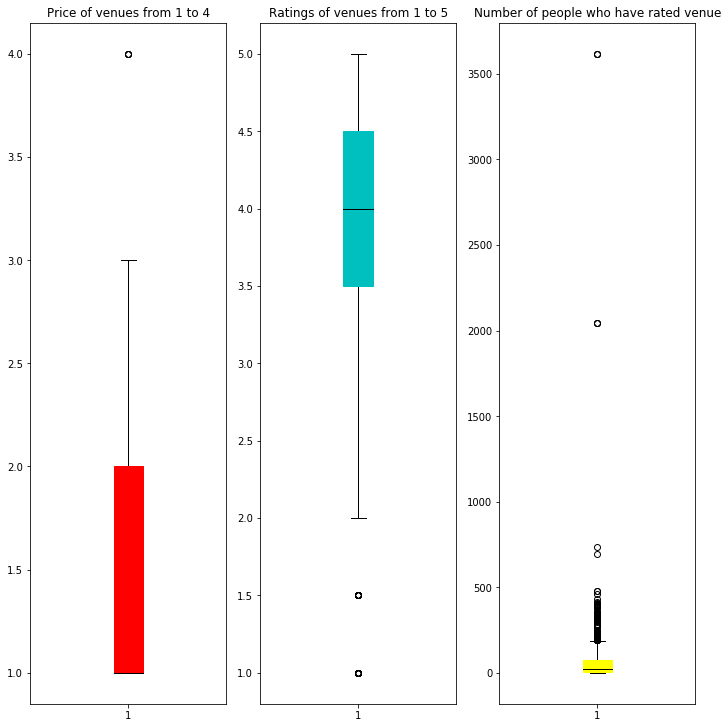

In [230]:
import matplotlib as mat
import matplotlib.pyplot as plt
# subplots containing a boxplot for price, ratings, and number of ratings
fig, (ax1, ax2, ax3)=plt.subplots(nrows=1,ncols=3,constrained_layout=True,figsize=[10,10])
PriceBP=ax1.boxplot(KC['Price'],patch_artist=True)
ax1.set_title('Price of venues from 1 to 4')
plt.setp(PriceBP['boxes'],color='r')
plt.setp(PriceBP['medians'],color='black')
RatingBP=ax2.boxplot(KC['Rating'],patch_artist=True)
ax2.set_title('Ratings of venues from 1 to 5')
plt.setp(RatingBP['boxes'],color='c')
plt.setp(RatingBP['medians'],color='black')
NumRatBP=ax3.boxplot(KC['Number of Ratings'],patch_artist=True)
ax3.set_title('Number of people who have rated venue')
plt.setp(NumRatBP['boxes'],color='yellow')
plt.setp(NumRatBP['medians'],color='black')

There are few outliers in price and ratings, but a lot in number of ratings. This isn't surprisng considering many venues have 10 or under number of ratings but there are quite a sizeable amount with 100s

[None]

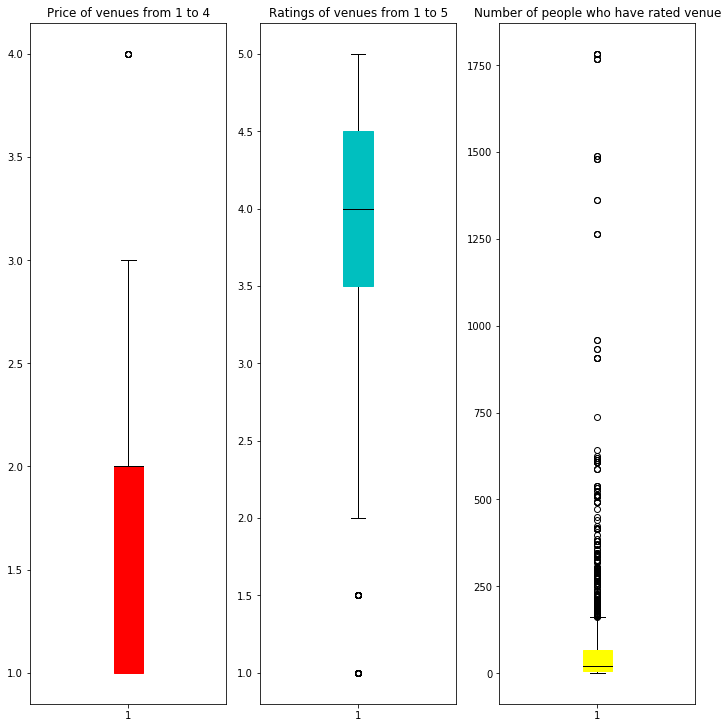

In [229]:
# now for STL boxplots
fig2, (ax4, ax5, ax6)=plt.subplots(nrows=1,ncols=3,constrained_layout=True,figsize=[10,10])
STLPriceBP=ax4.boxplot(STL['Price'],patch_artist=True)
ax4.set_title('Price of venues from 1 to 4')
plt.setp(STLPriceBP['boxes'],color='r')
plt.setp(STLPriceBP['medians'],color='black')
STLRatingBP=ax5.boxplot(STL['Rating'],patch_artist=True)
ax5.set_title('Ratings of venues from 1 to 5')
plt.setp(STLRatingBP['boxes'],color='c')
plt.setp(STLRatingBP['medians'],color='black')
STLNumRatBP=ax6.boxplot(STL['Number of Ratings'],patch_artist=True)
ax6.set_title('Number of people who have rated venue')
plt.setp(STLNumRatBP['boxes'],color='yellow')
plt.setp(STLNumRatBP['medians'],color='black')

The distributions are very similar for price and ratings for both areas but STL seems to have more venues with large amount of people who have rated it. 

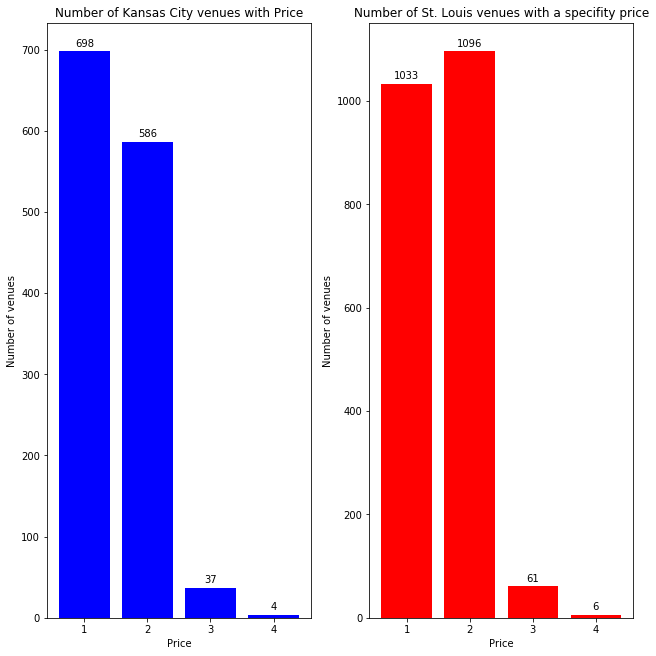

In [311]:
# now we'll look at bar graph of price for both Kansas City and St. Louis since it is technically a categorical variable 
fig, (axkc, axstl)=plt.subplots(nrows=1,ncols=2,constrained_layout=True,figsize=[9,9])
pricecount=list(KC[['Venue','Price']].groupby('Price').count().reset_index()['Venue'])
KCprices=list(KC[['Price']].groupby('Price').count().index)
kcbar=axkc.bar(KCprices,height=pricecount,color='blue',align='center')
stlpricecount=list(STL[['Venue','Price']].groupby('Price').count().reset_index()['Venue'])
STLprices=list(STL[['Price']].groupby('Price').count().index)
stlbar=axstl.bar(STLprices,height=stlpricecount,color='red',align='center')
axkc.set_xticks(KCprices)
axstl.set_xticks(STLprices)
axkc.set_title('Number of Kansas City venues with Price')
axstl.set_title('Number of St. Louis venues with a specifity price')
axkc.set_xlabel('Price')
axstl.set_xlabel('Price')
axkc.set_ylabel('Number of venues')
axstl.set_ylabel('Number of venues')
def autolabel(rects,ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(kcbar,axkc)
autolabel(stlbar,axstl)

It's now understandable why average price is higher in STL. There are significanlty more price 2 venues in STL than in Kansas City. 

Text(0.5, 1.0, 'number of STL venues with a rating')

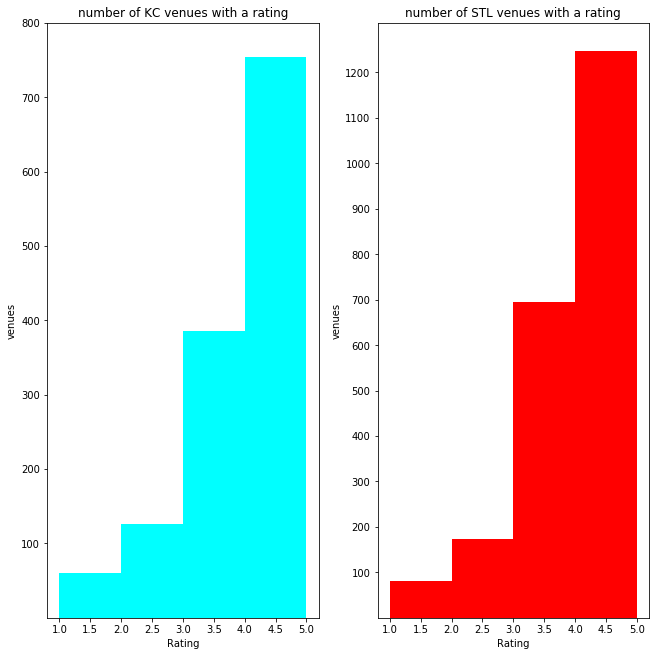

In [327]:
fig, (axkc2, axstl2)=plt.subplots(nrows=1,ncols=2,constrained_layout=True, figsize=[9,9])
kchist=axkc2.hist(KC['Rating'],bins=[1,2,3,4,5],color='cyan')
stlhist=(axstl2).hist(STL['Rating'],bins=[1,2,3,4,5],color='red')
#note that the last bin includes 4 and 5's while the others don't include the right number
axkc2.set_xlabel('Rating')
axstl2.set_xlabel('Rating')
axkc2.set_ylabel('venues')
axstl2.set_ylabel('venues')
axstl2.set_yticks(np.arange(100,1300,100))
axkc2.set_yticks(np.arange(100,900,100))
axkc2.set_title('number of KC venues with a rating')
axstl2.set_title('number of STL venues with a rating')

Once again it must be noted that STL has more venues 4 or greater rating. However, STL has more venues than kansas city with almost 2:1 ration (stl has 2200 while kc has 1300). Therefore, it should be no surprise to this disparity. Realistically, no transformation of the data will fix this type of distribution since neither are completely continuous. Now we are going to multiply number of ratings with ratings for each venue to get an approximate total score for each venue. This is done because the average rating will most likely be skewed in some way. 

In [331]:
#first for KC calculating a total venue score
scores=[]
for score, num in zip(KC['Rating'],KC['Number of Ratings']):
    scores.append(score*num)
scoresdf=pd.DataFrame(data=scores,columns=['Total Venue Score'])
KC2=KC.join(scoresdf)
KC2

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings,Total Venue Score
0,"Kansas City, Missouri",39.099792,-94.578559,Zaina,568c885e498e68d35094a34a,Mediterranean Restaurant,1,4.0,207,828.0
1,"Kansas City, Missouri",39.099792,-94.578559,Sprint Center,4abb8024f964a520df8320e3,Stadium,2,3.5,126,441.0
2,"Kansas City, Missouri",39.099792,-94.578559,Reserve,500ddff7e8896e4419038cae,New American Restaurant,2,4.0,141,564.0
3,"Kansas City, Missouri",39.099792,-94.578559,Onelife Fitness,5422006a498e41bc7ee2b6a0,Gym,2,4.5,71,319.5
4,"Kansas City, Missouri",39.099792,-94.578559,Flying Saucer,4ae39f1cf964a520589721e3,Beer Bar,2,4.0,459,1836.0
...,...,...,...,...,...,...,...,...,...,...
1320,"River Bend, Missouri",39.175075,-94.394215,hammerhand (Hammerhand Coffee),57efb75f498ed51bfe1d0343,Coffee Shop,1,4.5,72,324.0
1321,"River Bend, Missouri",39.175075,-94.394215,Hy-Vee,4cd009f07b685481f9f0bef8,Grocery Store,2,4.0,25,100.0
1322,"River Bend, Missouri",39.175075,-94.394215,Oceans Of Fun,4ad4c01ff964a5202ff220e3,Theme Park,1,3.0,39,117.0
1323,"River Bend, Missouri",39.175075,-94.394215,A Little BBQ Joint,5166f50fe4b02747bfd6ee0e,BBQ Joint,2,4.5,393,1768.5


In [332]:
#STL calculations of total venue score
scores=[]
for score, num in zip(STL['Rating'],STL['Number of Ratings']):
    scores.append(score*num)
scoresdf=pd.DataFrame(data=scores,columns=['Total Venue Score'])
STL2=STL.join(scoresdf)
STL2

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings,Total Venue Score
0,"Berger, Missouri",38.676288,-91.336237,Hermann Wurst Haus,4e569ed5227140cf12f7aa27,Butcher,2,4.0,136,544.0
1,"Berger, Missouri",38.676288,-91.336237,Oak Glenn Winery,4d87aeab81fdb1f784a23dc0,Winery,2,3.0,55,165.0
2,"Berger, Missouri",38.676288,-91.336237,Wings-A-Blazin',4b68c884f964a520c08c2be3,Wings Joint,1,3.5,61,213.5
3,"Berger, Missouri",38.676288,-91.336237,Vintage 1847 Restaurant,4c9179faae45224b3773e897,German Restaurant,1,4.5,22,99.0
4,"Berger, Missouri",38.676288,-91.336237,Tin Mill Brewing Co,4b92ec1af964a5204c2734e3,Brewery,2,3.5,86,301.0
...,...,...,...,...,...,...,...,...,...,...
2191,"Washington Park, Illinois",38.636862,-90.093102,La Gardenia,4fff1936e4b0f1ba28c411e9,Mexican Restaurant,2,4.0,68,272.0
2192,"Washington Park, Illinois",38.636862,-90.093102,Dairy Haven,4bc24f4174a9a5932f26d3f6,Ice Cream Shop,1,4.5,31,139.5
2193,"Washington Park, Illinois",38.636862,-90.093102,Monk's Mound,4da0869f54dd8cfa19a55c72,Park,1,4.5,54,243.0
2194,"Washington Park, Illinois",38.636862,-90.093102,Gateway National Golf Links,4bd46c3c4e32d13a510abf80,Golf Course,2,4.5,13,58.5


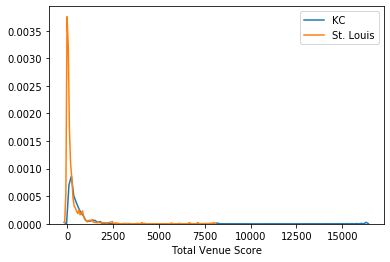

In [339]:
import seaborn as sns
sns.distplot(KC2['Total Venue Score'],hist=False,label='KC')
sns.distplot(STL2['Total Venue Score'],hist=False,label="St. Louis")

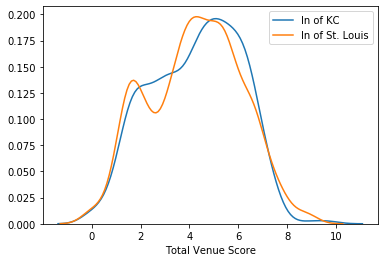

In [347]:
#observing the change in distribution by using the log10 transformation
sns.distplot(np.log(KC2['Total Venue Score']),hist=False,label='ln of KC')
sns.distplot(np.log(STL2['Total Venue Score']),hist=False,label="ln of St. Louis")

It appears that the natural log transformation does make the total venue score appear more normally distributed. Thus it seems to be a good choice for transformation

In [366]:
#adding the natual log of total score to the dataframes
lnTVC=pd.DataFrame(list(np.log(KC2['Total Venue Score'])),columns=['Ln Total Venue Score'])
KC3=KC2.join(lnTVC)
KC3.head(15)

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings,Total Venue Score,Ln Total Venue Score
0,"Kansas City, Missouri",39.099792,-94.578559,Zaina,568c885e498e68d35094a34a,Mediterranean Restaurant,1,4.0,207,828.0,6.719013
1,"Kansas City, Missouri",39.099792,-94.578559,Sprint Center,4abb8024f964a520df8320e3,Stadium,2,3.5,126,441.0,6.089045
2,"Kansas City, Missouri",39.099792,-94.578559,Reserve,500ddff7e8896e4419038cae,New American Restaurant,2,4.0,141,564.0,6.335054
3,"Kansas City, Missouri",39.099792,-94.578559,Onelife Fitness,5422006a498e41bc7ee2b6a0,Gym,2,4.5,71,319.5,5.766757
4,"Kansas City, Missouri",39.099792,-94.578559,Flying Saucer,4ae39f1cf964a520589721e3,Beer Bar,2,4.0,459,1836.0,7.515345
5,"Kansas City, Missouri",39.099792,-94.578559,Polished Nail Salon,4d30beda10e9b1f76e11bef1,Salon / Barbershop,2,3.5,134,469.0,6.150603
6,"Kansas City, Missouri",39.099792,-94.578559,Cosentino's Market Downtown,4b3014ddf964a520baf524e3,Supermarket,2,4.0,287,1148.0,7.045777
7,"Kansas City, Missouri",39.099792,-94.578559,Zoo Bar,4b2c45f4f964a52004c524e3,Dive Bar,1,4.5,72,324.0,5.780744
8,"Kansas City, Missouri",39.099792,-94.578559,Bristol Seafood Grill,4aef2751f964a5201bd621e3,Seafood Restaurant,3,4.5,385,1732.5,7.457321
9,"Kansas City, Missouri",39.099792,-94.578559,Arvest Bank Theatre at the Midland,4ad4c01ff964a520eef120e3,Music Venue,2,4.0,121,484.0,6.182085


In [367]:
lnTVC=pd.DataFrame(list(np.log(STL2['Total Venue Score'])),columns=['Ln Total Venue Score'])
STL3=STL2.join(lnTVC)
STL3.head(15)

,Location,City_lat,City_long,Venue,Venue ID,Venue Category,Price,Rating,Number of Ratings,Total Venue Score,Ln Total Venue Score
0,"Berger, Missouri",38.676288,-91.336237,Hermann Wurst Haus,4e569ed5227140cf12f7aa27,Butcher,2,4.0,136,544.0,6.298949
1,"Berger, Missouri",38.676288,-91.336237,Oak Glenn Winery,4d87aeab81fdb1f784a23dc0,Winery,2,3.0,55,165.0,5.105945
2,"Berger, Missouri",38.676288,-91.336237,Wings-A-Blazin',4b68c884f964a520c08c2be3,Wings Joint,1,3.5,61,213.5,5.363637
3,"Berger, Missouri",38.676288,-91.336237,Vintage 1847 Restaurant,4c9179faae45224b3773e897,German Restaurant,1,4.5,22,99.0,4.595120
4,"Berger, Missouri",38.676288,-91.336237,Tin Mill Brewing Co,4b92ec1af964a5204c2734e3,Brewery,2,3.5,86,301.0,5.707110
5,"Berger, Missouri",38.676288,-91.336237,Battocletti Bake Shoppe,4bad1e6bf964a520842f3be3,Bakery,1,4.0,10,40.0,3.688879
6,"Berger, Missouri",38.676288,-91.336237,Casey's General Store,4ced2fee840a9eb0e4f59f13,Pizza Place,1,5.0,1,5.0,1.609438
7,"Berger, Missouri",38.676288,-91.336237,Subway,4d0fd840cf09a143fcfb270f,Sandwich Place,1,1.0,1,1.0,0.000000
8,"Berger, Missouri",38.676288,-91.336237,Lyndee's Restaurant,4bbe83e330c99c7446f75311,American Restaurant,1,3.5,14,49.0,3.891820
9,"Berger, Missouri",38.676288,-91.336237,Save-A-Lot,4bb2aca514cfd13a384e15ab,Grocery Store,1,3.0,2,6.0,1.791759


Now we can move on to creating dummy variables for the categories, after combining KC and STL dataframes

In [381]:
#combining kc and stl dataframes
KCSTL=KC3.append(STL3)
print(KCSTL.shape)
print(KCSTL.head(15))
print(KCSTL.tail(15))

(3521, 11)
                 Location   City_lat  City_long  \
0   Kansas City, Missouri  39.099792 -94.578559   
1   Kansas City, Missouri  39.099792 -94.578559   
2   Kansas City, Missouri  39.099792 -94.578559   
3   Kansas City, Missouri  39.099792 -94.578559   
4   Kansas City, Missouri  39.099792 -94.578559   
5   Kansas City, Missouri  39.099792 -94.578559   
6   Kansas City, Missouri  39.099792 -94.578559   
7   Kansas City, Missouri  39.099792 -94.578559   
8   Kansas City, Missouri  39.099792 -94.578559   
9   Kansas City, Missouri  39.099792 -94.578559   
10  Kansas City, Missouri  39.099792 -94.578559   
11  Kansas City, Missouri  39.099792 -94.578559   
12  Kansas City, Missouri  39.099792 -94.578559   
13  Kansas City, Missouri  39.099792 -94.578559   
14  Kansas City, Missouri  39.099792 -94.578559   

                                 Venue                  Venue ID  \
0                                Zaina  568c885e498e68d35094a34a   
1                        Sprint Cent

In [383]:
KCSTL=KCSTL.reset_index()
print(KCSTL.head())
print(KCSTL.tail())

   level_0  index               Location   City_lat  City_long  \
0        0      0  Kansas City, Missouri  39.099792 -94.578559   
1        1      1  Kansas City, Missouri  39.099792 -94.578559   
2        2      2  Kansas City, Missouri  39.099792 -94.578559   
3        3      3  Kansas City, Missouri  39.099792 -94.578559   
4        4      4  Kansas City, Missouri  39.099792 -94.578559   

             Venue                  Venue ID            Venue Category  Price  \
0            Zaina  568c885e498e68d35094a34a  Mediterranean Restaurant      1   
1    Sprint Center  4abb8024f964a520df8320e3                   Stadium      2   
2          Reserve  500ddff7e8896e4419038cae   New American Restaurant      2   
3  Onelife Fitness  5422006a498e41bc7ee2b6a0                       Gym      2   
4    Flying Saucer  4ae39f1cf964a520589721e3                  Beer Bar      2   

   Rating  Number of Ratings  Total Venue Score  Ln Total Venue Score  
0     4.0                207              82

In [386]:
#creating dummy variables for the combined data frame
KCSTLdummies=pd.get_dummies(KCSTL[['Venue Category']])
KCSTLdummies['Location']=KCSTL[['Location']]
KCSTLfin=KCSTLdummies.groupby('Location').mean().reset_index()
print(KCSTLfin.shape)
KCSTLfin.head()

(324, 247)


,Location,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Airport Service,Venue Category_American Restaurant,Venue Category_Antique Shop,Venue Category_Arcade,Venue Category_Argentinian Restaurant,Venue Category_Art Gallery,Venue Category_Arts & Crafts Store,...,Venue Category_Warehouse Store,Venue Category_Water Park,Venue Category_Wine Bar,Venue Category_Wine Shop,Venue Category_Winery,Venue Category_Wings Joint,Venue Category_Women's Store,Venue Category_Yoga Studio,Venue Category_Zoo,Venue Category_Zoo Exhibit
0,"Albers, Illinois",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0
1,"Alhambra, Illinois",0.0,0.0,0.0,0.285714,0.142857,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Alorton, Illinois",0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Alton, Illinois",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Arnold, Missouri",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [396]:
#inserting the expected value of price (mean) and mean of total venue score for each location to final dataframe for 
#analysis. We will also rescale the data to be between 0 and 1 for price an ln totla venue score
# in order to be in the same range as mean of venue categories
meanprice=np.array(KCSTL.groupby('Location')['Price'].mean())
minavgprice=meanprice.min()
maxavgprice=meanprice.max()
pricescale=(meanprice-minavgprice)/(maxavgprice-minavgprice)
KCSTLfin['Price']=list(pricescale)
meanlnscore=np.array(KCSTL.groupby('Location')['Ln Total Venue Score'].mean())
minavglnscore=meanlnscore.min()
maxavglnscore=meanlnscore.max()
lnscorescaled=list((meanlnscore-minavglnscore)/(maxavglnscore-minavglnscore))
KCSTLfin['Ln Total Venue Score']=lnscorescaled
print(KCSTLfin.shape)
KCSTLfin.head(10)

(324, 249)


,Location,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Airport Service,Venue Category_American Restaurant,Venue Category_Antique Shop,Venue Category_Arcade,Venue Category_Argentinian Restaurant,Venue Category_Art Gallery,Venue Category_Arts & Crafts Store,...,Venue Category_Wine Bar,Venue Category_Wine Shop,Venue Category_Winery,Venue Category_Wings Joint,Venue Category_Women's Store,Venue Category_Yoga Studio,Venue Category_Zoo,Venue Category_Zoo Exhibit,Price,Ln Total Venue Score
0,"Albers, Illinois",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.1,0.000000,0.0,0.0,0.0,0.0,0.214286,0.330852
1,"Alhambra, Illinois",0.0,0.0,0.0,0.285714,0.142857,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.510204,0.449767
2,"Alorton, Illinois",0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.952381,0.682812
3,"Alton, Illinois",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.446429,0.639507
4,"Arnold, Missouri",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.214286,0.550898
5,"Aviston, Illinois",0.0,0.0,0.0,0.100000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.1,0.000000,0.0,0.0,0.0,0.0,0.214286,0.497190
6,"Avondale, Missouri",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.338346,0.748950
7,"Ballwin, Missouri",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.476190,0.647068
8,"Barnhart, Missouri",0.0,0.0,0.0,0.400000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.285714,0.625003
9,"Bartelso, Illinois",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.178571,0.393550


In [397]:
#comparing to last columns to make sure it looks right.
KCSTLfin.groupby('Location')['Ln Total Venue Score'].mean().head(10)

Location
Albers,  Illinois      0.330852
Alhambra,  Illinois    0.449767
Alorton,  Illinois     0.682812
Alton,  Illinois       0.639507
Arnold,  Missouri      0.550898
Aviston,  Illinois     0.497190
Avondale,  Missouri    0.748950
Ballwin,  Missouri     0.647068
Barnhart,  Missouri    0.625003
Bartelso,  Illinois    0.393550
Name: Ln Total Venue Score, dtype: float64

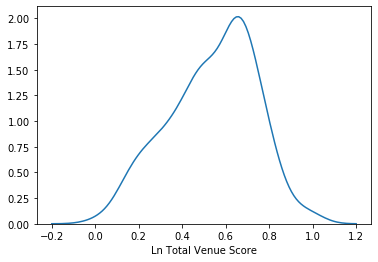

In [398]:
sns.distplot(KCSTLfin['Ln Total Venue Score'],hist=False)

looks different because it is a combination of the two distributions but it is still somewhat close to a normal distribution.

### Part 3: clustering the cities

Text(0, 0.5, 'scores (minimization function output)')

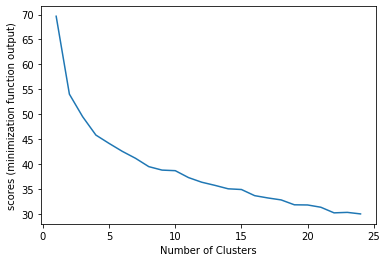

In [407]:
from sklearn.cluster import KMeans
scores=[]
KCSTLfin2=KCSTLfin.iloc[:,1:]
# set number of clusters
for kclusters in range(1,25):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0,n_init=15).fit(KCSTLfin2)

    # check scores for k-means clustering
    scores.append(kmeans.score(KCSTLfin2)*-1)
#plot scores of k-means clustering to decide how many clusters to have
k=np.array(range(1,25))
plt.plot(k,scores)
plt.xlabel('Number of Clusters')
plt.ylabel('scores (minimization function output)')

It appears that there is no obvious choice for number of clusters with kmeans. However, at 10 there appears to be a slight bent and it ends up being a slow and steady decrease with not much change. 

In [408]:
#repeating the cluster calculation but for 10 clusters
NumofClusters=10
kmeans2=KMeans(n_clusters=NumofClusters,random_state=0,n_init=15).fit(KCSTLfin2)
print(kmeans2.labels_)
print(len(kmeans2.labels_))

[1 3 5 6 4 9 4 6 3 9 6 3 4 4 6 9 4 6 3 1 9 4 3 4 3 6 9 4 9 6 9 0 5 9 1 9 9
 4 9 9 1 0 3 0 5 4 4 5 6 6 5 4 0 2 6 2 6 6 6 3 4 0 5 9 1 1 6 2 6 6 1 9 4 3
 4 9 5 9 6 6 4 6 6 0 6 0 6 4 6 1 3 2 3 0 7 6 2 4 6 0 5 1 0 9 1 9 9 1 4 3 9
 4 6 3 1 6 3 6 3 4 4 4 9 4 7 4 7 9 9 4 4 6 9 9 9 5 0 0 5 3 3 2 1 6 7 4 5 9
 7 2 6 5 3 3 6 4 3 1 3 5 0 4 6 1 0 1 4 9 0 9 3 6 6 4 0 0 9 6 4 4 9 0 4 6 6
 4 1 9 9 1 1 1 1 9 9 0 6 0 9 4 2 2 4 3 9 6 4 1 4 1 0 6 1 0 1 0 6 4 6 4 4 9
 6 2 9 1 3 0 6 9 0 1 6 0 3 6 6 6 9 2 6 1 4 6 9 4 6 9 1 9 5 1 1 4 3 9 5 1 9
 0 0 6 9 9 4 4 1 9 4 8 4 3 6 9 3 9 3 6 3 4 1 6 1 3 9 0 3 0 6 6 6 3 9 6 6 5
 4 1 0 0 6 3 3 3 6 5 6 6 5 1 4 3 6 5 1 4 3 1 6 1 9 6 2 0]
324


In [421]:
KCSTLfin2['Location']=KCSTLfin['Location']
KCSTLfin2.head()

,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Airport Service,Venue Category_American Restaurant,Venue Category_Antique Shop,Venue Category_Arcade,Venue Category_Argentinian Restaurant,Venue Category_Art Gallery,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,...,Venue Category_Wine Shop,Venue Category_Winery,Venue Category_Wings Joint,Venue Category_Women's Store,Venue Category_Yoga Studio,Venue Category_Zoo,Venue Category_Zoo Exhibit,Price,Ln Total Venue Score,Location
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.214286,0.330852,"Albers, Illinois"
1,0.0,0.0,0.0,0.285714,0.142857,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.510204,0.449767,"Alhambra, Illinois"
2,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.952381,0.682812,"Alorton, Illinois"
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.446429,0.639507,"Alton, Illinois"
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214286,0.550898,"Arnold, Missouri"


In [432]:
#geting latitude and longitude for each city to then combine with final data frame
citylatlong=pd.DataFrame(KCSTL.groupby('Location')['City_lat','City_long'].mean()).reset_index()
citylatlong.head(10)

,Location,City_lat,City_long
0,"Albers, Illinois",38.543260,-89.616930
1,"Alhambra, Illinois",38.888271,-89.735890
2,"Alorton, Illinois",38.580174,-90.118019
3,"Alton, Illinois",38.903341,-90.149352
4,"Arnold, Missouri",38.432229,-90.378504
5,"Aviston, Illinois",38.610424,-89.607993
6,"Avondale, Missouri",39.154765,-94.544840
7,"Ballwin, Missouri",38.595104,-90.544918
8,"Barnhart, Missouri",38.341267,-90.393405
9,"Bartelso, Illinois",38.536509,-89.469113


In [433]:
#combining latitude, longitude, and kmeans labels to the final dataframe
KCSTLfin3=KCSTLfin2.merge(citylatlong,on=['Location'])
KCSTLfin3['Cluster Label']=kmeans2.labels_
KCSTLfin3.head(10)

,Venue Category_ATM,Venue Category_Accessories Store,Venue Category_Airport Service,Venue Category_American Restaurant,Venue Category_Antique Shop,Venue Category_Arcade,Venue Category_Argentinian Restaurant,Venue Category_Art Gallery,Venue Category_Arts & Crafts Store,Venue Category_Asian Restaurant,...,Venue Category_Women's Store,Venue Category_Yoga Studio,Venue Category_Zoo,Venue Category_Zoo Exhibit,Price,Ln Total Venue Score,Location,City_lat,City_long,Cluster Label
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.214286,0.330852,"Albers, Illinois",38.543260,-89.616930,1
1,0.0,0.0,0.0,0.285714,0.142857,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.510204,0.449767,"Alhambra, Illinois",38.888271,-89.735890,3
2,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.952381,0.682812,"Alorton, Illinois",38.580174,-90.118019,5
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.446429,0.639507,"Alton, Illinois",38.903341,-90.149352,6
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.214286,0.550898,"Arnold, Missouri",38.432229,-90.378504,4
5,0.0,0.0,0.0,0.100000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.214286,0.497190,"Aviston, Illinois",38.610424,-89.607993,9
6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.338346,0.748950,"Avondale, Missouri",39.154765,-94.544840,4
7,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.476190,0.647068,"Ballwin, Missouri",38.595104,-90.544918,6
8,0.0,0.0,0.0,0.400000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.285714,0.625003,"Barnhart, Missouri",38.341267,-90.393405,3
9,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.178571,0.393550,"Bartelso, Illinois",38.536509,-89.469113,9


In [434]:
#putting the cities on the map but with color this time
mapOfBothMetros=folium.Map(location=[midpointlat,midpointlong],zoom_start=6)
colors=['red','blue','green','purple','orange','beige','pink','gray','black','cadetblue']
for lat, long, city, clus in zip(KCSTLfin3['City_lat'],KCSTLfin3['City_long'],KCSTLfin3['Location'],KCSTLfin3['Cluster Label']):
    label='{}'.format(city)
    label=folium.Popup(label,parse_html=True)
    folium.Marker(
        location=[lat,long],
        popup=label,
        icon=folium.Icon(color=colors[clus],icon='fa-building',prefix='fa')
    ).add_to(mapOfBothMetros)

mapOfBothMetros

### Part 4: Analyzing the clusters
We will look at each cluster in order to see the cities that compose them and what are the categories, price, and scores of that cluster

In [487]:
#for cluster 0
#getting the price, natural log of venue score, and categories
#we will also consider the more popular venues instead of all of them since there will be a lot of venues that are present
#at least once
colind=KCSTLfin3.loc[KCSTLfin3['Cluster Label']==0,].mean()>.02
print(list(KCSTLfin3.loc[KCSTLfin3['Cluster Label']==0,]['Location']))
KCSTLfin3.loc[KCSTLfin3['Cluster Label']==0,].describe().loc[:,list(colind)]

['Brighton,  Illinois', 'Carlyle,  Illinois', 'Centralia,  Illinois', 'Columbia,  Illinois', 'Damiansville,  Illinois', 'Elsberry,  Missouri', 'Excelsior Springs,  Missouri', 'Fidelity,  Illinois', 'Freeburg,  Illinois', 'Garden City,  Missouri', 'Hoffman,  Illinois', 'Huey,  Illinois', 'Lebanon,  Illinois', 'Levasy,  Missouri', 'Lone Jack,  Missouri', 'Marine,  Illinois', 'Marissa,  Illinois', 'Medora,  Illinois', 'New Haven,  Missouri', 'Nilwood,  Illinois', 'Old Ripley,  Illinois', 'Osborn,  Missouri', 'Otterville,  Illinois', 'Pierron,  Illinois', 'Plattsburg,  Missouri', 'Pocahontas,  Illinois', 'Smithton,  Illinois', 'Smithville,  Missouri', 'Truesdale,  Missouri', 'Union,  Missouri', 'Wamac,  Illinois', 'Warrenton,  Missouri', 'Wright City,  Missouri']


,Venue Category_American Restaurant,Venue Category_Discount Store,Venue Category_Fast Food Restaurant,Venue Category_Gas Station,Venue Category_Ice Cream Shop,Venue Category_Mexican Restaurant,Venue Category_Pharmacy,Venue Category_Pizza Place,Venue Category_Sandwich Place,Venue Category_Steakhouse,Venue Category_Video Game Store,Venue Category_Wine Bar,Price,Ln Total Venue Score,City_lat
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.00000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.027513,0.107239,0.024916,0.062939,0.027104,0.068855,0.023064,0.134512,0.05000,0.021669,0.035101,0.035005,0.564351,0.368278,38.842741
std,0.051698,0.102036,0.049751,0.100715,0.045975,0.102222,0.042313,0.192863,0.06087,0.056487,0.105487,0.079934,0.115163,0.109769,0.372860
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.428571,0.144523,38.249347
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.500000,0.294339,38.539502
50%,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.00000,0.000000,0.000000,0.000000,0.535714,0.390971,38.811266
75%,0.000000,0.200000,0.000000,0.111111,0.050000,0.100000,0.000000,0.200000,0.10000,0.000000,0.000000,0.000000,0.571429,0.468739,39.133546
max,0.150000,0.333333,0.200000,0.333333,0.111111,0.333333,0.111111,1.000000,0.20000,0.250000,0.500000,0.333333,1.000000,0.522361,39.750596


This 0 cluster has a decently high cost of venues with not so great quality. There seems to be quite a bit of food and some forms for entertainment. This is perhaps a place where some families go to live but it turns out not to be that great. Most of these cities are in the STL area. In both areas though these cities are on the outskirst of their respective metros. Thus, one could say this is cluster describes small town/villages environment.

In [476]:
#for cluster 1
colind=KCSTLfin3.loc[KCSTLfin3['Cluster Label']==1,].mean()>.02
print(list(KCSTLfin3.loc[KCSTLfin3['Cluster Label']==1,]['Location']))
KCSTLfin3.loc[KCSTLfin3['Cluster Label']==1,].describe().loc[:,list(colind)]

['Albers,  Illinois', 'Benld,  Illinois', 'Buckner,  Missouri', 'Carlinville,  Illinois', 'De Soto,  Missouri', 'Dearborn,  Missouri', 'Dorchester,  Illinois', 'Fayetteville,  Illinois', 'Fults,  Illinois', 'Gerald,  Missouri', 'Girard,  Illinois', 'Gower,  Missouri', 'Jerseyville,  Illinois', 'Lawson,  Missouri', 'Lenzburg,  Illinois', 'Lexington,  Missouri', 'Modesto,  Illinois', 'Mount Clare,  Illinois', 'Mount Olive,  Illinois', 'Mulberry Grove,  Illinois', 'New Athens,  Illinois', 'Odessa,  Missouri', 'Old Monroe,  Missouri', 'Osawatomie,  Kansas', 'Ottawa,  Kansas', 'Peculiar,  Missouri', 'Pleasant Hill,  Missouri', 'Richmond,  Missouri', 'Royal Lakes,  Illinois', 'Sawyerville,  Illinois', 'Shattuc,  Illinois', 'Sibley,  Missouri', 'St. Clair,  Missouri', 'Tonganoxie,  Kansas', 'Trenton,  Illinois', 'Virden,  Illinois', 'Wellsville,  Kansas', 'White City,  Illinois', 'Wilsonville,  Illinois', 'Winfield,  Missouri']


,Venue Category_American Restaurant,Venue Category_Campground,Venue Category_Convenience Store,Venue Category_Discount Store,Venue Category_Farm,Venue Category_Fast Food Restaurant,Venue Category_Gas Station,Venue Category_Ice Cream Shop,Venue Category_Mexican Restaurant,Venue Category_Pizza Place,Venue Category_Sandwich Place,Price,Ln Total Venue Score,City_lat,Cluster Label
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.0
mean,0.031528,0.037500,0.044444,0.154277,0.027500,0.056888,0.029028,0.043611,0.037610,0.130240,0.105259,0.062990,0.216936,38.923731,1.0
std,0.054844,0.166613,0.086808,0.091884,0.097223,0.080682,0.054013,0.063187,0.055882,0.106129,0.095910,0.068489,0.077714,0.402909,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.134270,1.0
25%,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.037500,0.000000,0.173946,38.607753,1.0
50%,0.000000,0.000000,0.000000,0.146429,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.071429,0.225949,39.071132,1.0
75%,0.087500,0.000000,0.087500,0.205556,0.000000,0.102778,0.016667,0.100000,0.100000,0.200000,0.135417,0.089286,0.260057,39.147993,1.0
max,0.200000,1.000000,0.333333,0.300000,0.500000,0.272727,0.200000,0.200000,0.200000,0.400000,0.500000,0.285714,0.354064,39.613118,1.0


Cluster 1 is really cheap, but the quality is not great. Also, it appears that these are more smaller towns far away from downtowns of each metro area. Perhaps the most rural grouping of cities. 

In [488]:
#for cluster 2
colind=KCSTLfin3.loc[KCSTLfin3['Cluster Label']==2,].mean()>.02
print(list(KCSTLfin3.loc[KCSTLfin3['Cluster Label']==2,]['Location']))
KCSTLfin3.loc[KCSTLfin3['Cluster Label']==2,].describe().loc[:,list(colind)]

['Cool Valley,  Missouri', 'Country Club Hills,  Missouri', 'Dellwood,  Missouri', 'Ferguson,  Missouri', 'Flordell Hills,  Missouri', 'Jennings,  Missouri', 'Kinloch,  Missouri', 'Northwoods,  Missouri', 'Norwood Court,  Missouri', 'Pasadena Hills,  Missouri', 'Raytown,  Missouri', 'Worden,  Illinois']


,Venue Category_Bar,Venue Category_Brewery,Venue Category_Chinese Restaurant,Venue Category_Convenience Store,Venue Category_Cosmetics Shop,Venue Category_Diner,Venue Category_Farmers Market,Venue Category_Golf Course,Venue Category_Grocery Store,Venue Category_Park,Venue Category_Sandwich Place,Venue Category_Theater,Price,Ln Total Venue Score,City_lat,Cluster Label
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0
mean,0.020833,0.093275,0.022904,0.067580,0.045370,0.115741,0.025926,0.062963,0.166167,0.026852,0.064559,0.062963,0.554946,0.483416,38.767359,2.0
std,0.072169,0.033631,0.043866,0.052766,0.056150,0.083881,0.046981,0.055724,0.071434,0.048654,0.057266,0.055724,0.066964,0.038210,0.094322,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.476190,0.433965,38.705303,2.0
25%,0.000000,0.100000,0.000000,0.000000,0.000000,0.075000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.500000,0.460701,38.717985,2.0
50%,0.000000,0.105556,0.000000,0.100000,0.000000,0.111111,0.000000,0.100000,0.141447,0.000000,0.102632,0.100000,0.555556,0.473840,38.726811,2.0
75%,0.000000,0.111111,0.013158,0.111111,0.111111,0.200000,0.025000,0.111111,0.205556,0.025000,0.111111,0.111111,0.571429,0.510591,38.753961,2.0
max,0.250000,0.111111,0.111111,0.125000,0.111111,0.222222,0.111111,0.111111,0.333333,0.111111,0.125000,0.111111,0.714286,0.553566,38.994380,2.0


Cluster 2 seems to be more downtown focused considering the high price and more unique and with more entertainment categories in for this grouping. Also, all the green ones are close, if not in, downtown. The quality though in these areas isn't good for downtown cities. This is perhaps a place where a mixture of travelers and people living in these cities.

In [489]:
#for cluster 3
colind=KCSTLfin3.loc[KCSTLfin3['Cluster Label']==3,].mean()>.02
print(list(KCSTLfin3.loc[KCSTLfin3['Cluster Label']==3,]['Location']))
KCSTLfin3.loc[KCSTLfin3['Cluster Label']==3,].describe().loc[:,list(colind)]

['Alhambra,  Illinois', 'Barnhart,  Missouri', 'Beckemeyer,  Illinois', 'Belton,  Missouri', 'Bethalto,  Illinois', 'Black Jack,  Missouri', 'Caseyville,  Illinois', 'Crystal City,  Missouri', 'East Alton,  Illinois', 'Fenton,  Missouri', 'Festus,  Missouri', 'Glen Carbon,  Illinois', 'Godfrey,  Illinois', 'Grain Valley,  Missouri', 'Granite City,  Illinois', 'Imperial,  Missouri', 'Independence,  Missouri', 'Lake Lotawana,  Missouri', 'Lake St. Louis,  Missouri', 'Lansing,  Kansas', 'Leavenworth,  Kansas', 'Madison,  Illinois', "O'Fallon,  Missouri", 'Pevely,  Missouri', 'Pontoon Beach,  Illinois', 'Shiloh,  Illinois', 'St. Paul,  Missouri', 'Sugar Creek,  Missouri', 'Summerfield,  Illinois', 'Swansea,  Illinois', 'Troy,  Illinois', 'Twin Oaks,  Missouri', 'Valley Park,  Missouri', 'Washington Park,  Illinois', 'Washington,  Missouri', 'Waterloo,  Illinois', 'West Alton,  Missouri', 'Wildwood,  Missouri']


,Venue Category_American Restaurant,Venue Category_Bar,Venue Category_Brewery,Venue Category_Coffee Shop,Venue Category_Convenience Store,Venue Category_Grocery Store,Venue Category_Ice Cream Shop,Venue Category_Italian Restaurant,Venue Category_Mexican Restaurant,Venue Category_Pizza Place,Price,Ln Total Venue Score,City_lat,Cluster Label
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.0
mean,0.159970,0.025292,0.022295,0.032302,0.021045,0.044164,0.075682,0.023753,0.059718,0.079594,0.419131,0.599443,38.710251,3.0
std,0.103423,0.043662,0.049709,0.045197,0.048010,0.051715,0.065121,0.052974,0.079338,0.072946,0.092382,0.081075,0.267607,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.238095,0.443181,38.219667,3.0
25%,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.361842,0.537656,38.557101,3.0
50%,0.137500,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,0.428571,0.615308,38.716750,3.0
75%,0.216667,0.037500,0.000000,0.088158,0.000000,0.100000,0.108333,0.000000,0.100000,0.111111,0.500000,0.647991,38.879267,3.0
max,0.400000,0.111111,0.200000,0.111111,0.222222,0.157895,0.222222,0.200000,0.333333,0.222222,0.571429,0.787705,39.327460,3.0


The price is fair and the quality is decent considering the price. This appears to be some suburbs in the metro areas that are not inexpensive to live int. There are standard variety of restaurants and not much entertainment venues that are popular.

In [490]:
#for cluster 4
colind=KCSTLfin3.loc[KCSTLfin3['Cluster Label']==4,].mean()>.02
print(list(KCSTLfin3.loc[KCSTLfin3['Cluster Label']==4,]['Location']))
KCSTLfin3.loc[KCSTLfin3['Cluster Label']==4,].describe().loc[:,list(colind)]

['Arnold,  Missouri', 'Avondale,  Missouri', 'Bel-Nor,  Missouri', 'Bel-Ridge,  Missouri', 'Bellerive,  Missouri', 'Berkeley,  Missouri', 'Beverly Hills,  Missouri', 'Breckenridge Hills,  Missouri', 'Cahokia,  Illinois', 'Champ,  Missouri', 'Charlack,  Missouri', 'Collinsville,  Illinois', 'Crystal Lake Park,  Missouri', 'Dupo,  Illinois', 'East Carondelet,  Illinois', 'Edwardsville,  Kansas', 'Fairview Heights,  Illinois', 'Florissant,  Missouri', 'Gladstone,  Missouri', 'Glenaire,  Missouri', 'Grantwood Village,  Missouri', 'Green Park,  Missouri', 'Greendale,  Missouri', 'Greenwood,  Missouri', 'Hanley Hills,  Missouri', 'Hazelwood,  Missouri', 'Hecker,  Illinois', 'Kansas City,  Kansas', 'Lakeshire,  Missouri', "Lee's Summit,  Missouri", 'Liberty,  Missouri', 'Maplewood,  Missouri', 'Maryland Heights,  Missouri', 'Maryville,  Illinois', 'Merriam,  Kansas', 'Mission,  Kansas', 'North Kansas City,  Missouri', "O'Fallon,  Illinois", 'Oaks,  Missouri', 'Olathe,  Kansas', 'Overland,  Mi

,Venue Category_American Restaurant,Venue Category_BBQ Joint,Venue Category_Bakery,Venue Category_Brewery,Venue Category_Burger Joint,Venue Category_Chinese Restaurant,Venue Category_Coffee Shop,Venue Category_Convenience Store,Venue Category_Diner,Venue Category_Fast Food Restaurant,Venue Category_Grocery Store,Venue Category_Ice Cream Shop,Venue Category_Mexican Restaurant,Venue Category_Park,Venue Category_Pizza Place,Venue Category_Sandwich Place,Price,Ln Total Venue Score,City_lat,Cluster Label
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.0
mean,0.020923,0.021437,0.021085,0.030344,0.030805,0.027518,0.035321,0.054251,0.021914,0.025049,0.030339,0.041147,0.055377,0.032608,0.025135,0.041233,0.291346,0.689935,38.779014,4.0
std,0.036648,0.039204,0.038503,0.056277,0.045825,0.051196,0.045968,0.071582,0.045268,0.046855,0.044972,0.061051,0.066908,0.050442,0.041790,0.048797,0.078330,0.080721,0.224952,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.536194,38.305158,4.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.238095,0.645923,38.622575,4.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.676269,38.712418,4.0
75%,0.050000,0.037500,0.037500,0.050000,0.088158,0.050000,0.052632,0.100000,0.000000,0.037500,0.088889,0.100000,0.103947,0.088158,0.050000,0.100000,0.357143,0.726201,38.905792,4.0
max,0.111111,0.111111,0.111111,0.200000,0.111111,0.200000,0.166667,0.222222,0.200000,0.200000,0.111111,0.222222,0.222222,0.200000,0.157895,0.150000,0.428571,0.973018,39.244739,4.0


This is a bang for your buck type group where one gets some great quality venues while remaining relatively affordable. Once again though this group mostly consists of suburbs in each metro area. 

In [491]:
#for cluster 5
colind=KCSTLfin3.loc[KCSTLfin3['Cluster Label']==5,].mean()>.02
print(list(KCSTLfin3.loc[KCSTLfin3['Cluster Label']==5,]['Location']))
KCSTLfin3.loc[KCSTLfin3['Cluster Label']==5,].describe().loc[:,list(colind)]

['Alorton,  Illinois', 'Brooklyn,  Illinois', 'Centreville,  Illinois', 'Chesterfield,  Missouri', 'Clayton,  Missouri', 'Dardenne Prairie,  Missouri', 'East St. Louis,  Illinois', 'Frontenac,  Missouri', 'Hillsdale,  Missouri', 'Huntleigh,  Missouri', 'Kansas City, Missouri', 'Ladue,  Missouri', 'Leawood,  Kansas', 'Sauget,  Illinois', 'Shrewsbury,  Missouri', 'Venice,  Illinois', 'Webster Groves,  Missouri', 'Wellston,  Missouri', 'Westwood,  Missouri']


,Venue Category_American Restaurant,Venue Category_BBQ Joint,Venue Category_Breakfast Spot,Venue Category_Brewery,Venue Category_Coffee Shop,Venue Category_Golf Course,Venue Category_Grocery Store,Venue Category_Hotel,Venue Category_Ice Cream Shop,Venue Category_Italian Restaurant,Venue Category_Mexican Restaurant,Venue Category_Park,Venue Category_Pizza Place,Venue Category_Steakhouse,Price,Ln Total Venue Score,City_lat,Cluster Label
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0
mean,0.125439,0.047953,0.021053,0.026901,0.028947,0.021053,0.021053,0.026901,0.023684,0.081579,0.027485,0.026316,0.042690,0.047953,0.713241,0.847366,38.676717,5.0
std,0.098502,0.049247,0.053530,0.066079,0.045080,0.041885,0.041885,0.046306,0.042060,0.096048,0.047339,0.056195,0.051489,0.061759,0.133197,0.096974,0.128230,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.670692,38.574752,5.0
25%,0.075000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.642857,0.796493,38.606583,5.0
50%,0.100000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.678571,0.821528,38.640746,5.0
75%,0.200000,0.100000,0.000000,0.000000,0.075000,0.000000,0.000000,0.050000,0.025000,0.100000,0.050000,0.000000,0.100000,0.100000,0.785714,0.906454,38.673586,5.0
max,0.333333,0.111111,0.200000,0.200000,0.100000,0.100000,0.100000,0.111111,0.100000,0.300000,0.111111,0.200000,0.111111,0.200000,1.000000,1.000000,39.099792,5.0


Cluster 5 is the "upper class" group. It has the highest quality but also the highest price. From the venues and map, these are suburbs in their respective metro areas but there are some attractions for the locals and visitors. In other words, this group is not just for families to live.

In [495]:
#for cluster 6
colind=KCSTLfin3.loc[KCSTLfin3['Cluster Label']==6,].mean()>.02
print(list(KCSTLfin3.loc[KCSTLfin3['Cluster Label']==6,]['Location']))
KCSTLfin3.loc[KCSTLfin3['Cluster Label']==6,].describe().loc[:,list(colind)]

['Alton,  Illinois', 'Ballwin,  Missouri', 'Basehor,  Kansas', 'Bella Villa,  Missouri', 'Belleville,  Illinois', 'Blue Springs,  Missouri', 'Brentwood,  Missouri', 'Clarkson Valley,  Missouri', 'Claycomo,  Missouri', 'Cottleville,  Missouri', 'Country Life Acres,  Missouri', 'Crestwood,  Missouri', 'Creve Coeur,  Missouri', 'Defiance,  Missouri', 'Des Peres,  Missouri', 'Donnellson,  Illinois', 'Edmundson,  Missouri', 'Edwardsville,  Illinois', 'Ellisville,  Missouri', 'Elsah,  Illinois', 'Eureka,  Missouri', 'Fairmont City,  Illinois', 'Fairway,  Kansas', 'Flint Hill,  Missouri', 'Foristell,  Missouri', 'Glendale,  Missouri', 'Grafton,  Illinois', 'Grandview,  Missouri', 'Herculaneum,  Missouri', 'Josephville,  Missouri', 'Kirkwood,  Missouri', 'Lake Tapawingo,  Missouri', 'Lenexa,  Kansas', 'Maeystown,  Illinois', 'Manchester,  Missouri', 'Marthasville,  Missouri', 'Millstadt,  Illinois', 'Mission Hills,  Kansas', 'New Melle,  Missouri', 'Oakland,  Missouri', 'Olivette,  Missouri', 

,Venue Category_American Restaurant,Venue Category_BBQ Joint,Venue Category_Bar,Venue Category_Coffee Shop,Venue Category_Fast Food Restaurant,Venue Category_Grocery Store,Venue Category_Ice Cream Shop,Venue Category_Italian Restaurant,Venue Category_Mexican Restaurant,Venue Category_Park,Venue Category_Pizza Place,Venue Category_Sandwich Place,Price,Ln Total Venue Score,City_lat,Cluster Label
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.0
mean,0.030392,0.020178,0.044769,0.029040,0.021242,0.042727,0.027328,0.023856,0.036842,0.032800,0.059757,0.022467,0.567996,0.682489,38.775487,6.0
std,0.051969,0.039131,0.059349,0.042882,0.040279,0.069954,0.045987,0.047472,0.062170,0.057437,0.075757,0.043070,0.080891,0.071356,0.231089,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.541110,38.225720,6.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.636990,38.607986,6.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.555556,0.679981,38.707725,6.0
75%,0.050000,0.000000,0.100000,0.050000,0.000000,0.100000,0.050000,0.012500,0.050000,0.050000,0.100000,0.050000,0.634921,0.729515,38.971079,6.0
max,0.222222,0.125000,0.250000,0.125000,0.111111,0.300000,0.166667,0.250000,0.333333,0.300000,0.333333,0.222222,0.714286,0.815704,39.238187,6.0


Cluster 6 appears to be a high quality group of suburbs (but not as much as cluster 5) but at a reasonable price. However, it looks like these cities have more focus on living their than visiting as a tourist. 

In [496]:
#for cluster 7
colind=KCSTLfin3.loc[KCSTLfin3['Cluster Label']==7,].mean()>.02
print(list(KCSTLfin3.loc[KCSTLfin3['Cluster Label']==7,]['Location']))
KCSTLfin3.loc[KCSTLfin3['Cluster Label']==7,].describe().loc[:,list(colind)]

['Fieldon,  Illinois', 'Hamel,  Illinois', 'Hardin,  Illinois', 'Kampsville,  Illinois', 'Keyesport,  Illinois']


,Venue Category_American Restaurant,Venue Category_Bar,Venue Category_Construction & Landscaping,Venue Category_Grocery Store,Venue Category_River,Venue Category_Seafood Restaurant,Venue Category_Truck Stop,Venue Category_Wine Bar,Price,Ln Total Venue Score,City_lat,Cluster Label
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0
mean,0.066667,0.566667,0.066667,0.050000,0.100000,0.050000,0.050000,0.050000,0.750000,0.419554,39.039621,7.0
std,0.149071,0.252763,0.149071,0.111803,0.223607,0.111803,0.111803,0.111803,0.079860,0.228732,0.221143,0.0
min,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.714286,0.063952,38.744508,7.0
25%,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.714286,0.327154,38.889026,7.0
50%,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.714286,0.525670,39.108650,7.0
75%,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.714286,0.542648,39.156764,7.0
max,0.333333,1.000000,0.333333,0.250000,0.500000,0.250000,0.250000,0.250000,0.892857,0.638347,39.299158,7.0


5 cities that are on the outskirst of the St. Louis metro area. The price is high but that's most likely due to the venues in them. The cities seem to have more venues that focus on the outdoors and appear to be quite small. Most seem to be by the river.

In [497]:
#for cluster 8
colind=KCSTLfin3.loc[KCSTLfin3['Cluster Label']==8,].mean()>.02
print(list(KCSTLfin3.loc[KCSTLfin3['Cluster Label']==8,]['Location']))
KCSTLfin3.loc[KCSTLfin3['Cluster Label']==8,].describe().loc[:,list(colind)]

['St. Libory,  Illinois']


,Venue Category_Auto Garage,Price,Ln Total Venue Score,City_lat,Cluster Label
count,1.0,1.000000,1.000000,1.00000,1.0
mean,1.0,0.714286,0.109327,38.36408,8.0
std,NaN,NaN,NaN,NaN,NaN
min,1.0,0.714286,0.109327,38.36408,8.0
25%,1.0,0.714286,0.109327,38.36408,8.0
50%,1.0,0.714286,0.109327,38.36408,8.0
75%,1.0,0.714286,0.109327,38.36408,8.0
max,1.0,0.714286,0.109327,38.36408,8.0


Cluster 8 brought to light that there is an outlier city. This city is on the outskirst and probably in a rural area. 

In [498]:
#for cluster 9
colind=KCSTLfin3.loc[KCSTLfin3['Cluster Label']==9,].mean()>.02
print(list(KCSTLfin3.loc[KCSTLfin3['Cluster Label']==9,]['Location']))
KCSTLfin3.loc[KCSTLfin3['Cluster Label']==9,].describe().loc[:,list(colind)]

['Aviston,  Illinois', 'Bartelso,  Illinois', 'Bellefontaine Neighbors,  Missouri', 'Berger,  Missouri', 'Bonner Springs,  Kansas', 'Breese,  Illinois', 'Bridgeton,  Missouri', 'Brussels,  Illinois', 'Bunker Hill,  Illinois', 'Byrnes Mill,  Missouri', 'Calverton Park,  Missouri', 'Cameron,  Missouri', 'De Soto,  Kansas', 'Drexel,  Missouri', 'East Gillespie,  Illinois', 'Edgerton,  Kansas', 'Gardner,  Kansas', 'Germantown,  Illinois', 'Gillespie,  Illinois', 'Glen Echo Park,  Missouri', 'Greenville,  Illinois', 'Harrisonville,  Missouri', 'Hartford,  Illinois', 'Higginsville,  Missouri', 'Highland,  Illinois', 'Hillsboro,  Missouri', 'Kearney,  Missouri', 'Livingston,  Illinois', 'Louisburg,  Kansas', 'Marlborough,  Missouri', 'Mascoutah,  Illinois', 'Moline Acres,  Missouri', 'Moscow Mills,  Missouri', 'New Baden,  Illinois', 'New Douglas,  Illinois', 'Normandy,  Missouri', 'Oak Grove,  Missouri', 'Paola,  Kansas', 'Pasadena Park,  Missouri', 'Platte City,  Missouri', 'Raymore,  Misso

,Venue Category_American Restaurant,Venue Category_Bar,Venue Category_Brewery,Venue Category_Convenience Store,Venue Category_Diner,Venue Category_Discount Store,Venue Category_Fast Food Restaurant,Venue Category_Grocery Store,Venue Category_Ice Cream Shop,Venue Category_Mexican Restaurant,Venue Category_Pizza Place,Venue Category_Sandwich Place,Price,Ln Total Venue Score,City_lat,Cluster Label
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.0
mean,0.051724,0.034617,0.026746,0.065141,0.035157,0.058151,0.056568,0.042473,0.053544,0.041761,0.081964,0.063150,0.182478,0.429675,38.801201,9.0
std,0.072619,0.061806,0.059544,0.085686,0.051983,0.070110,0.070643,0.065884,0.068230,0.061728,0.093646,0.061856,0.057582,0.074362,0.277323,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.266164,38.213599,9.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.378888,38.629013,9.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.081250,0.076316,0.178571,0.446951,38.759829,9.0
75%,0.100000,0.088158,0.000000,0.103947,0.100000,0.100000,0.100000,0.097727,0.100000,0.100000,0.121528,0.100000,0.214286,0.482963,38.969393,9.0
max,0.300000,0.333333,0.333333,0.333333,0.200000,0.200000,0.200000,0.222222,0.200000,0.200000,0.400000,0.222222,0.321429,0.562613,39.741205,9.0


Cluster 9 seemss to involve more suburbs. This time though while the price is low like cluster 4 the quality is not as good. Decent place to live due to cheap venues but not the greatest quality. 